In [1]:
%env ALL_PROXY=http://127.0.0.1:33001
%env HTTP_PROXY=http://127.0.0.1:33001
%env HTTPS_PROXY=http://127.0.0.1:33001

env: ALL_PROXY=http://127.0.0.1:33001
env: HTTP_PROXY=http://127.0.0.1:33001
env: HTTPS_PROXY=http://127.0.0.1:33001


In [2]:
!curl google.com

<HTML><HEAD><meta http-equiv="content-type" content="text/html;charset=utf-8">
<TITLE>301 Moved</TITLE></HEAD><BODY>
<H1>301 Moved</H1>
The document has moved
<A HREF="http://www.google.com/">here</A>.
</BODY></HTML>


# Import

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import wandb

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys
sys.path.insert(0, "/root/Soil-Column-Procedures")

from API_functions.DL import load_data, log, seed
from API_functions import file_batch as fb

# Hyperparameter and log

In [5]:
my_parameters = {
    'seed': 409,

    'Kfold': None,
    'ratio': 0.2,

    'model': '???',
    'optimizer': 'adam',
    'learning_rate':  0.0001,
    'batch_size': 32,
    'loss_function': 'cross_entropy',

    'n_epochs': 1000,
    'patience': 50,
}

device = 'cuda'
mylogger = log.Logger('all')

seed.stablize_seed(my_parameters['seed'])

In [6]:
wandb.init(
    project="U-Net",
    name='1l.using deep',
    config=my_parameters,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: laishixuan123 (laishixuan123-china-agricultural-university). Use `wandb login --relogin` to force relogin


# Transform

In [7]:
# # Define transformations and dataset
# transform_common = v2.Compose([
#     v2.ToTensor(),
#     v2.ToDtype(torch.float32),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.RandomVerticalFlip(p=0.5),
#     v2.RandomRotation(degrees=90),
# ])

# transform_train_special = v2.Compose([
#     v2.Normalize(mean=[0.5], std=[0.5]),
#     # v2.ColorJitter(brightness=0.1, contrast=0.1)
# ])

# transform_train = v2.Compose([
#     transform_common,
#     transform_train_special
# ])

# transform_train_label = transform_common

# transform_val = v2.Compose([
#     v2.ToTensor(),
#     v2.ToDtype(torch.float32)
# ])

# transform_test = transform_val

In [8]:
# For training data
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# For validation and test data
transform_val = A.Compose([
    ToTensorV2(),
])

# Load_data

In [9]:
def load_images(paths):
    return [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in paths]

data_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_images/', None, 'png')
labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_labels/', None, 'png')
test_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_images/', None, 'png')
test_labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_labels/', None, 'png')

data = load_images(data_paths)
labels = load_images(labels_paths)
tests = load_images(test_paths)
test_labels = load_images(test_labels_paths)

train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=my_parameters['ratio'], random_state=my_parameters['seed'])

train_dataset = load_data.my_Dataset(train_data, train_labels, transform=transform_train)
val_dataset = load_data.my_Dataset(val_data, val_labels, transform=transform_val)
test_dataset = load_data.my_Dataset(tests, test_labels, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=my_parameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_parameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=my_parameters['batch_size'], shuffle=False)

print(f'len of train_data: {len(train_data)}, len of val_data: {len(val_data)}, len of test_data: {len(tests)}')

10 images have been found in /root/Soil-Column-Procedures/data/version0/train_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12635.png
Get names completely!
10 images have been found in /root/Soil-Column-Procedures/data/version0/train_labels/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12635.png
Get names completely!
5 images have been found in /root/Soil-Column-Procedures/data/version0/test_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0

# Model

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets, smooth=1):
        # First, calculate the BCE loss
        inputs = torch.sigmoid(inputs)
        bce_loss = self.bce(inputs, targets)
        
        # Calculate Dice Loss
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        # Combine BCE + Dice
        return 0.5 * bce_loss + 0.5 * dice_loss

In [11]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:21<00:00, 4.04MB/s]


In [12]:
# model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=my_parameters['learning_rate'])
criterion = DiceBCELoss()

# Train

In [13]:
val_loss_best = 100000

for epoch in range(my_parameters['n_epochs']):
    model.train()
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if outputs.dim() == 4 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss_mean = train_loss / len(train_loader.dataset)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)

    val_loss_mean = val_loss / len(val_loader.dataset)
    dict = {'train_loss': train_loss_mean, 'epoch': epoch, 'val_loss': val_loss_mean}
    mylogger.log(dict)

    if val_loss_mean < val_loss_best:
        val_loss_best = val_loss_mean
        torch.save(model.state_dict(), 'model.pth')
        print(f'Model saved at epoch {epoch}, val_loss: {val_loss_mean}')

  0%|          | 0/1 [00:00<?, ?it/s]/root/Soil-Column-Procedures/API_functions/DL/load_data.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
/root/Soil-Column-Procedures/API_functions/DL/load_data.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label/255, dtype=torch.float32)
100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


{'epoch': 0, 'train_loss': 0.8351784944534302, 'val_loss': 0.8357040882110596}
Model saved at epoch 0, val_loss: 0.8357040882110596


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 1, 'train_loss': 0.8305479288101196, 'val_loss': 0.8296679258346558}
Model saved at epoch 1, val_loss: 0.8296679258346558


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 2, 'train_loss': 0.8253686428070068, 'val_loss': 0.8271923065185547}
Model saved at epoch 2, val_loss: 0.8271923065185547


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


{'epoch': 3, 'train_loss': 0.8206408023834229, 'val_loss': 0.8262757658958435}
Model saved at epoch 3, val_loss: 0.8262757658958435


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'epoch': 4, 'train_loss': 0.8165186643600464, 'val_loss': 0.8252013921737671}
Model saved at epoch 4, val_loss: 0.8252013921737671


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 5, 'train_loss': 0.810996949672699, 'val_loss': 0.8239776492118835}
Model saved at epoch 5, val_loss: 0.8239776492118835


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 6, 'train_loss': 0.8068661689758301, 'val_loss': 0.8222384452819824}
Model saved at epoch 6, val_loss: 0.8222384452819824


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


{'epoch': 7, 'train_loss': 0.8033155202865601, 'val_loss': 0.8209319114685059}
Model saved at epoch 7, val_loss: 0.8209319114685059


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


{'epoch': 8, 'train_loss': 0.7981299161911011, 'val_loss': 0.8202179074287415}
Model saved at epoch 8, val_loss: 0.8202179074287415


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 9, 'train_loss': 0.7928189635276794, 'val_loss': 0.8196715116500854}
Model saved at epoch 9, val_loss: 0.8196715116500854


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 10, 'train_loss': 0.7856725454330444, 'val_loss': 0.818534255027771}
Model saved at epoch 10, val_loss: 0.818534255027771


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 11, 'train_loss': 0.7811599373817444, 'val_loss': 0.8180497288703918}
Model saved at epoch 11, val_loss: 0.8180497288703918


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 12, 'train_loss': 0.7716712355613708, 'val_loss': 0.8177714347839355}
Model saved at epoch 12, val_loss: 0.8177714347839355


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 13, 'train_loss': 0.7660883665084839, 'val_loss': 0.8177574872970581}
Model saved at epoch 13, val_loss: 0.8177574872970581


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 14, 'train_loss': 0.7554337382316589, 'val_loss': 0.8179044723510742}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 15, 'train_loss': 0.7516958713531494, 'val_loss': 0.8177066445350647}
Model saved at epoch 15, val_loss: 0.8177066445350647


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 16, 'train_loss': 0.741216778755188, 'val_loss': 0.8165076971054077}
Model saved at epoch 16, val_loss: 0.8165076971054077


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 17, 'train_loss': 0.7366533279418945, 'val_loss': 0.8145604729652405}
Model saved at epoch 17, val_loss: 0.8145604729652405


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 18, 'train_loss': 0.7258297204971313, 'val_loss': 0.8118137717247009}
Model saved at epoch 18, val_loss: 0.8118137717247009


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 19, 'train_loss': 0.7186048030853271, 'val_loss': 0.808313250541687}
Model saved at epoch 19, val_loss: 0.808313250541687


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 20, 'train_loss': 0.713537871837616, 'val_loss': 0.8041559457778931}
Model saved at epoch 20, val_loss: 0.8041559457778931


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


{'epoch': 21, 'train_loss': 0.7085621953010559, 'val_loss': 0.799064040184021}
Model saved at epoch 21, val_loss: 0.799064040184021


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 22, 'train_loss': 0.7010915875434875, 'val_loss': 0.7934041023254395}
Model saved at epoch 22, val_loss: 0.7934041023254395


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 23, 'train_loss': 0.696886420249939, 'val_loss': 0.7872986197471619}
Model saved at epoch 23, val_loss: 0.7872986197471619


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


{'epoch': 24, 'train_loss': 0.6936171650886536, 'val_loss': 0.7817707061767578}
Model saved at epoch 24, val_loss: 0.7817707061767578


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 25, 'train_loss': 0.683984637260437, 'val_loss': 0.7762046456336975}
Model saved at epoch 25, val_loss: 0.7762046456336975


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


{'epoch': 26, 'train_loss': 0.6827022433280945, 'val_loss': 0.7707704305648804}
Model saved at epoch 26, val_loss: 0.7707704305648804


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 27, 'train_loss': 0.6758594512939453, 'val_loss': 0.764298677444458}
Model saved at epoch 27, val_loss: 0.764298677444458


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 28, 'train_loss': 0.6676939129829407, 'val_loss': 0.7577508687973022}
Model saved at epoch 28, val_loss: 0.7577508687973022


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 29, 'train_loss': 0.6680352687835693, 'val_loss': 0.7500264644622803}
Model saved at epoch 29, val_loss: 0.7500264644622803


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 30, 'train_loss': 0.6669051051139832, 'val_loss': 0.7382116317749023}
Model saved at epoch 30, val_loss: 0.7382116317749023


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 31, 'train_loss': 0.6542587280273438, 'val_loss': 0.7280821800231934}
Model saved at epoch 31, val_loss: 0.7280821800231934


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 32, 'train_loss': 0.6530254483222961, 'val_loss': 0.7193287014961243}
Model saved at epoch 32, val_loss: 0.7193287014961243


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 33, 'train_loss': 0.6487647891044617, 'val_loss': 0.7099051475524902}
Model saved at epoch 33, val_loss: 0.7099051475524902


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 34, 'train_loss': 0.6722568273544312, 'val_loss': 0.702217161655426}
Model saved at epoch 34, val_loss: 0.702217161655426


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 35, 'train_loss': 0.642199695110321, 'val_loss': 0.698515772819519}
Model saved at epoch 35, val_loss: 0.698515772819519


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 36, 'train_loss': 0.6389031410217285, 'val_loss': 0.7079397439956665}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 37, 'train_loss': 0.6355915665626526, 'val_loss': 0.7370246648788452}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 38, 'train_loss': 0.6334483623504639, 'val_loss': 0.7636228799819946}


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


{'epoch': 39, 'train_loss': 0.6311728954315186, 'val_loss': 0.744431734085083}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 40, 'train_loss': 0.6245871782302856, 'val_loss': 0.7310028672218323}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 41, 'train_loss': 0.6213732957839966, 'val_loss': 0.7065697908401489}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 42, 'train_loss': 0.6180105209350586, 'val_loss': 0.6962331533432007}
Model saved at epoch 42, val_loss: 0.6962331533432007


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 43, 'train_loss': 0.6148896217346191, 'val_loss': 0.6839536428451538}
Model saved at epoch 43, val_loss: 0.6839536428451538


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 44, 'train_loss': 0.6120373010635376, 'val_loss': 0.6781070828437805}
Model saved at epoch 44, val_loss: 0.6781070828437805


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 45, 'train_loss': 0.6076753735542297, 'val_loss': 0.6726664304733276}
Model saved at epoch 45, val_loss: 0.6726664304733276


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 46, 'train_loss': 0.6062310338020325, 'val_loss': 0.6665627360343933}
Model saved at epoch 46, val_loss: 0.6665627360343933


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 47, 'train_loss': 0.6022247672080994, 'val_loss': 0.659088134765625}
Model saved at epoch 47, val_loss: 0.659088134765625


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 48, 'train_loss': 0.5993199944496155, 'val_loss': 0.6537801623344421}
Model saved at epoch 48, val_loss: 0.6537801623344421


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 49, 'train_loss': 0.5964914560317993, 'val_loss': 0.6515480875968933}
Model saved at epoch 49, val_loss: 0.6515480875968933


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 50, 'train_loss': 0.5959739685058594, 'val_loss': 0.6527191996574402}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 51, 'train_loss': 0.5912157297134399, 'val_loss': 0.6514443159103394}
Model saved at epoch 51, val_loss: 0.6514443159103394


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'epoch': 52, 'train_loss': 0.5889257788658142, 'val_loss': 0.6488109827041626}
Model saved at epoch 52, val_loss: 0.6488109827041626


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 53, 'train_loss': 0.5851864814758301, 'val_loss': 0.6454370021820068}
Model saved at epoch 53, val_loss: 0.6454370021820068


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 54, 'train_loss': 0.5824090838432312, 'val_loss': 0.6417630910873413}
Model saved at epoch 54, val_loss: 0.6417630910873413


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 55, 'train_loss': 0.5815721750259399, 'val_loss': 0.6379681825637817}
Model saved at epoch 55, val_loss: 0.6379681825637817


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 56, 'train_loss': 0.5796632170677185, 'val_loss': 0.633657693862915}
Model saved at epoch 56, val_loss: 0.633657693862915


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 57, 'train_loss': 0.5765153765678406, 'val_loss': 0.6307237148284912}
Model saved at epoch 57, val_loss: 0.6307237148284912


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


{'epoch': 58, 'train_loss': 0.574009895324707, 'val_loss': 0.627747118473053}
Model saved at epoch 58, val_loss: 0.627747118473053


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 59, 'train_loss': 0.5724366903305054, 'val_loss': 0.6249278783798218}
Model saved at epoch 59, val_loss: 0.6249278783798218


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 60, 'train_loss': 0.5709558725357056, 'val_loss': 0.6227461099624634}
Model saved at epoch 60, val_loss: 0.6227461099624634


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 61, 'train_loss': 0.566893458366394, 'val_loss': 0.6204100847244263}
Model saved at epoch 61, val_loss: 0.6204100847244263


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 62, 'train_loss': 0.5666075944900513, 'val_loss': 0.6181081533432007}
Model saved at epoch 62, val_loss: 0.6181081533432007


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 63, 'train_loss': 0.5634645819664001, 'val_loss': 0.615152895450592}
Model saved at epoch 63, val_loss: 0.615152895450592


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


{'epoch': 64, 'train_loss': 0.5635308027267456, 'val_loss': 0.609504222869873}
Model saved at epoch 64, val_loss: 0.609504222869873


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 65, 'train_loss': 0.56136155128479, 'val_loss': 0.6020060777664185}
Model saved at epoch 65, val_loss: 0.6020060777664185


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 66, 'train_loss': 0.5627754926681519, 'val_loss': 0.6095166206359863}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 67, 'train_loss': 0.562548816204071, 'val_loss': 0.6119382381439209}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 68, 'train_loss': 0.5578035712242126, 'val_loss': 0.6069876551628113}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 69, 'train_loss': 0.5554606318473816, 'val_loss': 0.5891266465187073}
Model saved at epoch 69, val_loss: 0.5891266465187073


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 70, 'train_loss': 0.553913950920105, 'val_loss': 0.5971173644065857}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 71, 'train_loss': 0.5566458702087402, 'val_loss': 0.5941905975341797}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 72, 'train_loss': 0.550949215888977, 'val_loss': 0.6010648012161255}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 73, 'train_loss': 0.5549092888832092, 'val_loss': 0.5851971507072449}
Model saved at epoch 73, val_loss: 0.5851971507072449


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


{'epoch': 74, 'train_loss': 0.5517566204071045, 'val_loss': 0.5859143733978271}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 75, 'train_loss': 0.5453360080718994, 'val_loss': 0.5822550654411316}
Model saved at epoch 75, val_loss: 0.5822550654411316


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 76, 'train_loss': 0.5476800203323364, 'val_loss': 0.568988025188446}
Model saved at epoch 76, val_loss: 0.568988025188446


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


{'epoch': 77, 'train_loss': 0.5772659182548523, 'val_loss': 0.6309957504272461}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 78, 'train_loss': 0.5443012714385986, 'val_loss': 0.6905546188354492}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 79, 'train_loss': 0.5454682111740112, 'val_loss': 0.7154372930526733}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 80, 'train_loss': 0.5549037456512451, 'val_loss': 0.7172286510467529}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 81, 'train_loss': 0.5594688057899475, 'val_loss': 0.7164732813835144}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 82, 'train_loss': 0.5540216565132141, 'val_loss': 0.6938788890838623}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 83, 'train_loss': 0.5505155324935913, 'val_loss': 0.6637604236602783}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 84, 'train_loss': 0.5450493097305298, 'val_loss': 0.6327520608901978}


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


{'epoch': 85, 'train_loss': 0.5486061573028564, 'val_loss': 0.6119926571846008}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 86, 'train_loss': 0.5478584170341492, 'val_loss': 0.6043041944503784}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 87, 'train_loss': 0.5495688915252686, 'val_loss': 0.5964886546134949}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 88, 'train_loss': 0.5326446890830994, 'val_loss': 0.5895968675613403}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 89, 'train_loss': 0.5396534204483032, 'val_loss': 0.5902631282806396}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 90, 'train_loss': 0.5296510457992554, 'val_loss': 0.5890289545059204}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 91, 'train_loss': 0.537079930305481, 'val_loss': 0.5767320394515991}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 92, 'train_loss': 0.5305159091949463, 'val_loss': 0.5563032627105713}
Model saved at epoch 92, val_loss: 0.5563032627105713


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


{'epoch': 93, 'train_loss': 0.5280956625938416, 'val_loss': 0.555749773979187}
Model saved at epoch 93, val_loss: 0.555749773979187


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 94, 'train_loss': 0.5255541205406189, 'val_loss': 0.5589342713356018}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 95, 'train_loss': 0.5263252258300781, 'val_loss': 0.5623096227645874}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 96, 'train_loss': 0.5237940549850464, 'val_loss': 0.5619896054267883}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 97, 'train_loss': 0.5226998329162598, 'val_loss': 0.5597518086433411}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 98, 'train_loss': 0.5240453481674194, 'val_loss': 0.5564592480659485}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 99, 'train_loss': 0.5248391628265381, 'val_loss': 0.5522928833961487}
Model saved at epoch 99, val_loss: 0.5522928833961487


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 100, 'train_loss': 0.5279457569122314, 'val_loss': 0.5438723564147949}
Model saved at epoch 100, val_loss: 0.5438723564147949


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 101, 'train_loss': 0.5199422836303711, 'val_loss': 0.5523891448974609}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 102, 'train_loss': 0.5181683301925659, 'val_loss': 0.5799679160118103}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 103, 'train_loss': 0.5248275399208069, 'val_loss': 0.5695403218269348}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 104, 'train_loss': 0.5243909358978271, 'val_loss': 0.5466618537902832}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 105, 'train_loss': 0.5158671140670776, 'val_loss': 0.5136237740516663}
Model saved at epoch 105, val_loss: 0.5136237740516663


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 106, 'train_loss': 0.5165444016456604, 'val_loss': 0.5124671459197998}
Model saved at epoch 106, val_loss: 0.5124671459197998


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


{'epoch': 107, 'train_loss': 0.5187631845474243, 'val_loss': 0.512444257736206}
Model saved at epoch 107, val_loss: 0.512444257736206


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 108, 'train_loss': 0.5167242884635925, 'val_loss': 0.5159285664558411}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 109, 'train_loss': 0.5128869414329529, 'val_loss': 0.5171723961830139}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 110, 'train_loss': 0.5124727487564087, 'val_loss': 0.5164709091186523}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 111, 'train_loss': 0.5123612880706787, 'val_loss': 0.5132952928543091}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 112, 'train_loss': 0.5109673738479614, 'val_loss': 0.5132541060447693}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 113, 'train_loss': 0.5087860822677612, 'val_loss': 0.5210436582565308}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 114, 'train_loss': 0.5079653859138489, 'val_loss': 0.5283924341201782}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 115, 'train_loss': 0.5078117251396179, 'val_loss': 0.5282183289527893}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 116, 'train_loss': 0.5083338618278503, 'val_loss': 0.5718764066696167}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 117, 'train_loss': 0.5075969099998474, 'val_loss': 0.5726665258407593}


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


{'epoch': 118, 'train_loss': 0.5044378042221069, 'val_loss': 0.5636880993843079}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 119, 'train_loss': 0.504568874835968, 'val_loss': 0.5491222143173218}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 120, 'train_loss': 0.5231544971466064, 'val_loss': 0.5228931903839111}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 121, 'train_loss': 0.5039598941802979, 'val_loss': 0.4831962585449219}
Model saved at epoch 121, val_loss: 0.4831962585449219


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 122, 'train_loss': 0.50106281042099, 'val_loss': 0.48063305020332336}
Model saved at epoch 122, val_loss: 0.48063305020332336


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


{'epoch': 123, 'train_loss': 0.5049386024475098, 'val_loss': 0.4796432852745056}
Model saved at epoch 123, val_loss: 0.4796432852745056


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 124, 'train_loss': 0.50498366355896, 'val_loss': 0.48227059841156006}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 125,
 'train_loss': 0.5022246837615967,
 'val_loss': 0.48172640800476074}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 126, 'train_loss': 0.4995354413986206, 'val_loss': 0.4833793044090271}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 127,
 'train_loss': 0.5083317756652832,
 'val_loss': 0.48762229084968567}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 128,
 'train_loss': 0.49588337540626526,
 'val_loss': 0.49681347608566284}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 129, 'train_loss': 0.501859724521637, 'val_loss': 0.4856187105178833}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 130,
 'train_loss': 0.49671339988708496,
 'val_loss': 0.4803818464279175}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 131, 'train_loss': 0.4968997836112976, 'val_loss': 0.4796980917453766}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 132, 'train_loss': 0.4950770139694214, 'val_loss': 0.4783855378627777}
Model saved at epoch 132, val_loss: 0.4783855378627777


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 133,
 'train_loss': 0.49648386240005493,
 'val_loss': 0.4771507680416107}
Model saved at epoch 133, val_loss: 0.4771507680416107


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


{'epoch': 134,
 'train_loss': 0.5000619888305664,
 'val_loss': 0.47592973709106445}
Model saved at epoch 134, val_loss: 0.47592973709106445


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 135, 'train_loss': 0.494346559047699, 'val_loss': 0.4756101667881012}
Model saved at epoch 135, val_loss: 0.4756101667881012


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 136,
 'train_loss': 0.49121710658073425,
 'val_loss': 0.4757210910320282}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 137,
 'train_loss': 0.48800593614578247,
 'val_loss': 0.4761766791343689}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 138,
 'train_loss': 0.4882356524467468,
 'val_loss': 0.47647684812545776}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 139, 'train_loss': 0.4906853437423706, 'val_loss': 0.4766009449958801}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 140,
 'train_loss': 0.49020349979400635,
 'val_loss': 0.4751763641834259}
Model saved at epoch 140, val_loss: 0.4751763641834259


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 141, 'train_loss': 0.4888261556625366, 'val_loss': 0.4737486243247986}
Model saved at epoch 141, val_loss: 0.4737486243247986


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 142,
 'train_loss': 0.48793455958366394,
 'val_loss': 0.47255679965019226}
Model saved at epoch 142, val_loss: 0.47255679965019226


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 143, 'train_loss': 0.4869961440563202, 'val_loss': 0.4717605412006378}
Model saved at epoch 143, val_loss: 0.4717605412006378


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 144,
 'train_loss': 0.48337385058403015,
 'val_loss': 0.4708196520805359}
Model saved at epoch 144, val_loss: 0.4708196520805359


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 145, 'train_loss': 0.48741158843040466, 'val_loss': 0.46929731965065}
Model saved at epoch 145, val_loss: 0.46929731965065


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 146,
 'train_loss': 0.48241353034973145,
 'val_loss': 0.4686354100704193}
Model saved at epoch 146, val_loss: 0.4686354100704193


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 147,
 'train_loss': 0.5250823497772217,
 'val_loss': 0.46789324283599854}
Model saved at epoch 147, val_loss: 0.46789324283599854


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 148, 'train_loss': 0.4800248444080353, 'val_loss': 0.4890953600406647}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 149, 'train_loss': 0.483102947473526, 'val_loss': 0.704481840133667}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 150,
 'train_loss': 0.48853635787963867,
 'val_loss': 0.7986907958984375}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 151, 'train_loss': 0.48267829418182373, 'val_loss': 0.752478837966919}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 152, 'train_loss': 0.5002251863479614, 'val_loss': 0.6494643688201904}


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


{'epoch': 153,
 'train_loss': 0.47963887453079224,
 'val_loss': 0.5646518468856812}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 154,
 'train_loss': 0.49489641189575195,
 'val_loss': 0.5277495980262756}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 155,
 'train_loss': 0.4789993464946747,
 'val_loss': 0.48772284388542175}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 156, 'train_loss': 0.4900660514831543, 'val_loss': 0.4897769093513489}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 157,
 'train_loss': 0.48824334144592285,
 'val_loss': 0.48550140857696533}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 158, 'train_loss': 0.4748125672340393, 'val_loss': 0.4827035665512085}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 159, 'train_loss': 0.4850468933582306, 'val_loss': 0.4789377748966217}


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


{'epoch': 160, 'train_loss': 0.4748927652835846, 'val_loss': 0.4788266122341156}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 161, 'train_loss': 0.4746979773044586, 'val_loss': 0.4753749370574951}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 162,
 'train_loss': 0.47123050689697266,
 'val_loss': 0.4734155833721161}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 163, 'train_loss': 0.4737381339073181, 'val_loss': 0.4712735116481781}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 164, 'train_loss': 0.4709712862968445, 'val_loss': 0.4682372212409973}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 165,
 'train_loss': 0.4712420701980591,
 'val_loss': 0.46604251861572266}
Model saved at epoch 165, val_loss: 0.46604251861572266


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 166, 'train_loss': 0.4678862988948822, 'val_loss': 0.4641018509864807}
Model saved at epoch 166, val_loss: 0.4641018509864807


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 167,
 'train_loss': 0.46838295459747314,
 'val_loss': 0.4630906581878662}
Model saved at epoch 167, val_loss: 0.4630906581878662


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 168,
 'train_loss': 0.4669428765773773,
 'val_loss': 0.46275007724761963}
Model saved at epoch 168, val_loss: 0.46275007724761963


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 169,
 'train_loss': 0.46704035997390747,
 'val_loss': 0.46191146969795227}
Model saved at epoch 169, val_loss: 0.46191146969795227


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 170, 'train_loss': 0.4653683304786682, 'val_loss': 0.4603290855884552}
Model saved at epoch 170, val_loss: 0.4603290855884552


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 171,
 'train_loss': 0.4666564166545868,
 'val_loss': 0.45954522490501404}
Model saved at epoch 171, val_loss: 0.45954522490501404


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 172,
 'train_loss': 0.46055179834365845,
 'val_loss': 0.4581856429576874}
Model saved at epoch 172, val_loss: 0.4581856429576874


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 173, 'train_loss': 0.46315997838974, 'val_loss': 0.4560838043689728}
Model saved at epoch 173, val_loss: 0.4560838043689728


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 174,
 'train_loss': 0.4638773798942566,
 'val_loss': 0.45418938994407654}
Model saved at epoch 174, val_loss: 0.45418938994407654


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 175,
 'train_loss': 0.46070021390914917,
 'val_loss': 0.4521962106227875}
Model saved at epoch 175, val_loss: 0.4521962106227875


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


{'epoch': 176,
 'train_loss': 0.46086010336875916,
 'val_loss': 0.4511200785636902}
Model saved at epoch 176, val_loss: 0.4511200785636902


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 177,
 'train_loss': 0.46261700987815857,
 'val_loss': 0.4498974084854126}
Model saved at epoch 177, val_loss: 0.4498974084854126


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 178, 'train_loss': 0.4617047607898712, 'val_loss': 0.4525366723537445}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 179,
 'train_loss': 0.46504735946655273,
 'val_loss': 0.4525335431098938}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 180, 'train_loss': 0.464535653591156, 'val_loss': 0.46134570240974426}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 181,
 'train_loss': 0.46226218342781067,
 'val_loss': 0.4853971302509308}


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 182,
 'train_loss': 0.46380966901779175,
 'val_loss': 0.5218061208724976}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 183, 'train_loss': 0.4565221667289734, 'val_loss': 0.5622674226760864}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 184, 'train_loss': 0.456827849149704, 'val_loss': 0.5789834856987}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 185, 'train_loss': 0.4555310904979706, 'val_loss': 0.5791954398155212}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 186, 'train_loss': 0.4621104896068573, 'val_loss': 0.5804821252822876}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 187,
 'train_loss': 0.45525115728378296,
 'val_loss': 0.5648905038833618}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 188, 'train_loss': 0.453808069229126, 'val_loss': 0.5297696590423584}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 189,
 'train_loss': 0.47010642290115356,
 'val_loss': 0.5034725666046143}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 190, 'train_loss': 0.4523671567440033, 'val_loss': 0.5503419637680054}


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 191,
 'train_loss': 0.47337034344673157,
 'val_loss': 0.5525478720664978}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 192, 'train_loss': 0.4807582497596741, 'val_loss': 0.5249974727630615}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 193, 'train_loss': 0.46435391902923584, 'val_loss': 0.49724280834198}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 194,
 'train_loss': 0.47263461351394653,
 'val_loss': 0.4601496160030365}


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'epoch': 195,
 'train_loss': 0.47398775815963745,
 'val_loss': 0.45151078701019287}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 196, 'train_loss': 0.4722069501876831, 'val_loss': 0.4460809826850891}
Model saved at epoch 196, val_loss: 0.4460809826850891


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 197,
 'train_loss': 0.47473669052124023,
 'val_loss': 0.4423210322856903}
Model saved at epoch 197, val_loss: 0.4423210322856903


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 198, 'train_loss': 0.4553774297237396, 'val_loss': 0.4405946135520935}
Model saved at epoch 198, val_loss: 0.4405946135520935


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 199,
 'train_loss': 0.4625929892063141,
 'val_loss': 0.44007551670074463}
Model saved at epoch 199, val_loss: 0.44007551670074463


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 200, 'train_loss': 0.4470857083797455, 'val_loss': 0.4400594234466553}
Model saved at epoch 200, val_loss: 0.4400594234466553


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 201,
 'train_loss': 0.45873817801475525,
 'val_loss': 0.44090455770492554}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 202, 'train_loss': 0.44339561462402344, 'val_loss': 0.443628191947937}


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 203,
 'train_loss': 0.4540688395500183,
 'val_loss': 0.44651246070861816}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 204, 'train_loss': 0.4831068217754364, 'val_loss': 0.4474051296710968}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 205,
 'train_loss': 0.44471827149391174,
 'val_loss': 0.47396111488342285}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 206, 'train_loss': 0.4486181139945984, 'val_loss': 0.5188121199607849}


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 207,
 'train_loss': 0.44682449102401733,
 'val_loss': 0.6016334891319275}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 208, 'train_loss': 0.4459860920906067, 'val_loss': 0.5961824059486389}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 209, 'train_loss': 0.448735773563385, 'val_loss': 0.5759596824645996}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 210,
 'train_loss': 0.44345375895500183,
 'val_loss': 0.5683612823486328}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 211, 'train_loss': 0.4442960321903229, 'val_loss': 0.6028506755828857}


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 212, 'train_loss': 0.4478030502796173, 'val_loss': 0.6029188632965088}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 213,
 'train_loss': 0.44372689723968506,
 'val_loss': 0.5662825703620911}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 214, 'train_loss': 0.4383160471916199, 'val_loss': 0.527540922164917}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 215,
 'train_loss': 0.43684107065200806,
 'val_loss': 0.5009515881538391}


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


{'epoch': 216,
 'train_loss': 0.4350137710571289,
 'val_loss': 0.47855323553085327}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 217,
 'train_loss': 0.43313515186309814,
 'val_loss': 0.4613068103790283}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 218, 'train_loss': 0.4370291829109192, 'val_loss': 0.4536055326461792}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 219, 'train_loss': 0.432411253452301, 'val_loss': 0.45006999373435974}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 220,
 'train_loss': 0.43100476264953613,
 'val_loss': 0.4441104531288147}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 221,
 'train_loss': 0.42997801303863525,
 'val_loss': 0.44182032346725464}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 222,
 'train_loss': 0.4295399487018585,
 'val_loss': 0.43347465991973877}
Model saved at epoch 222, val_loss: 0.43347465991973877


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


{'epoch': 223,
 'train_loss': 0.42545565962791443,
 'val_loss': 0.42992931604385376}
Model saved at epoch 223, val_loss: 0.42992931604385376


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


{'epoch': 224,
 'train_loss': 0.42938655614852905,
 'val_loss': 0.43675464391708374}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 225,
 'train_loss': 0.42538541555404663,
 'val_loss': 0.43065497279167175}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 226, 'train_loss': 0.4211961328983307, 'val_loss': 0.4388004243373871}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 227,
 'train_loss': 0.42135342955589294,
 'val_loss': 0.4253380596637726}
Model saved at epoch 227, val_loss: 0.4253380596637726


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


{'epoch': 228, 'train_loss': 0.4206755459308624, 'val_loss': 0.4149283170700073}
Model saved at epoch 228, val_loss: 0.4149283170700073


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 229, 'train_loss': 0.4229942560195923, 'val_loss': 0.4132164418697357}
Model saved at epoch 229, val_loss: 0.4132164418697357


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


{'epoch': 230,
 'train_loss': 0.42113959789276123,
 'val_loss': 0.4132150411605835}
Model saved at epoch 230, val_loss: 0.4132150411605835


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 231, 'train_loss': 0.4208082854747772, 'val_loss': 0.4149094820022583}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 232,
 'train_loss': 0.42119672894477844,
 'val_loss': 0.4151712954044342}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 233,
 'train_loss': 0.42364755272865295,
 'val_loss': 0.41658422350883484}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 234,
 'train_loss': 0.41539546847343445,
 'val_loss': 0.4173516035079956}


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


{'epoch': 235,
 'train_loss': 0.41420111060142517,
 'val_loss': 0.41648998856544495}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 236,
 'train_loss': 0.4125015139579773,
 'val_loss': 0.42120811343193054}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 237,
 'train_loss': 0.41248905658721924,
 'val_loss': 0.4143107831478119}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 238,
 'train_loss': 0.41156110167503357,
 'val_loss': 0.40853792428970337}
Model saved at epoch 238, val_loss: 0.40853792428970337


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


{'epoch': 239, 'train_loss': 0.4142652153968811, 'val_loss': 0.4056386947631836}
Model saved at epoch 239, val_loss: 0.4056386947631836


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 240,
 'train_loss': 0.40878432989120483,
 'val_loss': 0.40349313616752625}
Model saved at epoch 240, val_loss: 0.40349313616752625


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 241,
 'train_loss': 0.4108370244503021,
 'val_loss': 0.40149086713790894}
Model saved at epoch 241, val_loss: 0.40149086713790894


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 242,
 'train_loss': 0.41422122716903687,
 'val_loss': 0.4005679786205292}
Model saved at epoch 242, val_loss: 0.4005679786205292


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 243,
 'train_loss': 0.40994393825531006,
 'val_loss': 0.3996674418449402}
Model saved at epoch 243, val_loss: 0.3996674418449402


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 244,
 'train_loss': 0.40514376759529114,
 'val_loss': 0.3991695046424866}
Model saved at epoch 244, val_loss: 0.3991695046424866


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


{'epoch': 245,
 'train_loss': 0.40531960129737854,
 'val_loss': 0.3989236354827881}
Model saved at epoch 245, val_loss: 0.3989236354827881


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 246,
 'train_loss': 0.4093429446220398,
 'val_loss': 0.39838504791259766}
Model saved at epoch 246, val_loss: 0.39838504791259766


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 247, 'train_loss': 0.4045143127441406, 'val_loss': 0.3977271020412445}
Model saved at epoch 247, val_loss: 0.3977271020412445


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


{'epoch': 248,
 'train_loss': 0.4045378267765045,
 'val_loss': 0.39732256531715393}
Model saved at epoch 248, val_loss: 0.39732256531715393


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 249,
 'train_loss': 0.4066372811794281,
 'val_loss': 0.39669424295425415}
Model saved at epoch 249, val_loss: 0.39669424295425415


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 250, 'train_loss': 0.4030604958534241, 'val_loss': 0.3953687250614166}
Model saved at epoch 250, val_loss: 0.3953687250614166


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 251, 'train_loss': 0.405444860458374, 'val_loss': 0.39343464374542236}
Model saved at epoch 251, val_loss: 0.39343464374542236


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 252, 'train_loss': 0.3989385664463043, 'val_loss': 0.3928765058517456}
Model saved at epoch 252, val_loss: 0.3928765058517456


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 253, 'train_loss': 0.399836927652359, 'val_loss': 0.3931942582130432}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 254,
 'train_loss': 0.39913299679756165,
 'val_loss': 0.39266881346702576}
Model saved at epoch 254, val_loss: 0.39266881346702576


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


{'epoch': 255, 'train_loss': 0.3964715301990509, 'val_loss': 0.3917981684207916}
Model saved at epoch 255, val_loss: 0.3917981684207916


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 256,
 'train_loss': 0.3960448205471039,
 'val_loss': 0.39134523272514343}
Model saved at epoch 256, val_loss: 0.39134523272514343


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 257,
 'train_loss': 0.3930502235889435,
 'val_loss': 0.39128008484840393}
Model saved at epoch 257, val_loss: 0.39128008484840393


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 258, 'train_loss': 0.39486178755760193, 'val_loss': 0.391029417514801}
Model saved at epoch 258, val_loss: 0.391029417514801


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 259,
 'train_loss': 0.38941165804862976,
 'val_loss': 0.39063799381256104}
Model saved at epoch 259, val_loss: 0.39063799381256104


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 260, 'train_loss': 0.3941962718963623, 'val_loss': 0.3898334205150604}
Model saved at epoch 260, val_loss: 0.3898334205150604


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 261,
 'train_loss': 0.39380043745040894,
 'val_loss': 0.38894331455230713}
Model saved at epoch 261, val_loss: 0.38894331455230713


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 262, 'train_loss': 0.3896523118019104, 'val_loss': 0.3869903087615967}
Model saved at epoch 262, val_loss: 0.3869903087615967


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 263,
 'train_loss': 0.3889167308807373,
 'val_loss': 0.38433703780174255}
Model saved at epoch 263, val_loss: 0.38433703780174255


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 264,
 'train_loss': 0.39093026518821716,
 'val_loss': 0.3822212219238281}
Model saved at epoch 264, val_loss: 0.3822212219238281


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 265,
 'train_loss': 0.39070582389831543,
 'val_loss': 0.38139209151268005}
Model saved at epoch 265, val_loss: 0.38139209151268005


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


{'epoch': 266,
 'train_loss': 0.3871731460094452,
 'val_loss': 0.38047584891319275}
Model saved at epoch 266, val_loss: 0.38047584891319275


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 267,
 'train_loss': 0.38629868626594543,
 'val_loss': 0.37861257791519165}
Model saved at epoch 267, val_loss: 0.37861257791519165


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 268,
 'train_loss': 0.38663649559020996,
 'val_loss': 0.3768998682498932}
Model saved at epoch 268, val_loss: 0.3768998682498932


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 269,
 'train_loss': 0.38482409715652466,
 'val_loss': 0.3755129277706146}
Model saved at epoch 269, val_loss: 0.3755129277706146


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 270, 'train_loss': 0.3851182162761688, 'val_loss': 0.375027060508728}
Model saved at epoch 270, val_loss: 0.375027060508728


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


{'epoch': 271, 'train_loss': 0.38409072160720825, 'val_loss': 0.374683141708374}
Model saved at epoch 271, val_loss: 0.374683141708374


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 272, 'train_loss': 0.3828068971633911, 'val_loss': 0.3736833333969116}
Model saved at epoch 272, val_loss: 0.3736833333969116


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 273,
 'train_loss': 0.38722866773605347,
 'val_loss': 0.3723779618740082}
Model saved at epoch 273, val_loss: 0.3723779618740082


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 274, 'train_loss': 0.38458728790283203, 'val_loss': 0.371380478143692}
Model saved at epoch 274, val_loss: 0.371380478143692


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


{'epoch': 275, 'train_loss': 0.3787078559398651, 'val_loss': 0.3702509105205536}
Model saved at epoch 275, val_loss: 0.3702509105205536


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 276,
 'train_loss': 0.3727169632911682,
 'val_loss': 0.37013551592826843}
Model saved at epoch 276, val_loss: 0.37013551592826843


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 277,
 'train_loss': 0.3805111348628998,
 'val_loss': 0.37075698375701904}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 278, 'train_loss': 0.3765895962715149, 'val_loss': 0.3716294765472412}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 279, 'train_loss': 0.3729259669780731, 'val_loss': 0.3721482455730438}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 280,
 'train_loss': 0.3740324378013611,
 'val_loss': 0.37343844771385193}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 281,
 'train_loss': 0.37431448698043823,
 'val_loss': 0.37486210465431213}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 282, 'train_loss': 0.3741637170314789, 'val_loss': 0.3719601631164551}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 283, 'train_loss': 0.371692031621933, 'val_loss': 0.3700675368309021}
Model saved at epoch 283, val_loss: 0.3700675368309021


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 284, 'train_loss': 0.3685140311717987, 'val_loss': 0.3690953552722931}
Model saved at epoch 284, val_loss: 0.3690953552722931


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 285, 'train_loss': 0.3677552044391632, 'val_loss': 0.3673088550567627}
Model saved at epoch 285, val_loss: 0.3673088550567627


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 286,
 'train_loss': 0.36488986015319824,
 'val_loss': 0.3649417757987976}
Model saved at epoch 286, val_loss: 0.3649417757987976


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 287,
 'train_loss': 0.36407938599586487,
 'val_loss': 0.3625911474227905}
Model saved at epoch 287, val_loss: 0.3625911474227905


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 288,
 'train_loss': 0.36655211448669434,
 'val_loss': 0.35963502526283264}
Model saved at epoch 288, val_loss: 0.35963502526283264


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


{'epoch': 289, 'train_loss': 0.365051805973053, 'val_loss': 0.35622093081474304}
Model saved at epoch 289, val_loss: 0.35622093081474304


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


{'epoch': 290,
 'train_loss': 0.36798912286758423,
 'val_loss': 0.35401850938796997}
Model saved at epoch 290, val_loss: 0.35401850938796997


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 291, 'train_loss': 0.364168643951416, 'val_loss': 0.35234248638153076}
Model saved at epoch 291, val_loss: 0.35234248638153076


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 292, 'train_loss': 0.3593776226043701, 'val_loss': 0.3512814939022064}
Model saved at epoch 292, val_loss: 0.3512814939022064


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


{'epoch': 293,
 'train_loss': 0.35842442512512207,
 'val_loss': 0.3507508337497711}
Model saved at epoch 293, val_loss: 0.3507508337497711


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


{'epoch': 294,
 'train_loss': 0.36169013381004333,
 'val_loss': 0.34889334440231323}
Model saved at epoch 294, val_loss: 0.34889334440231323


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 295,
 'train_loss': 0.3566807210445404,
 'val_loss': 0.34674522280693054}
Model saved at epoch 295, val_loss: 0.34674522280693054


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 296,
 'train_loss': 0.3569455146789551,
 'val_loss': 0.34494391083717346}
Model saved at epoch 296, val_loss: 0.34494391083717346


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 297, 'train_loss': 0.3623082637786865, 'val_loss': 0.3443444073200226}
Model saved at epoch 297, val_loss: 0.3443444073200226


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 298,
 'train_loss': 0.35348081588745117,
 'val_loss': 0.34427496790885925}
Model saved at epoch 298, val_loss: 0.34427496790885925


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 299,
 'train_loss': 0.35412541031837463,
 'val_loss': 0.3442027270793915}
Model saved at epoch 299, val_loss: 0.3442027270793915


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


{'epoch': 300,
 'train_loss': 0.35389888286590576,
 'val_loss': 0.3426083028316498}
Model saved at epoch 300, val_loss: 0.3426083028316498


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


{'epoch': 301,
 'train_loss': 0.35392385721206665,
 'val_loss': 0.3391971290111542}
Model saved at epoch 301, val_loss: 0.3391971290111542


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


{'epoch': 302, 'train_loss': 0.351001113653183, 'val_loss': 0.33657461404800415}
Model saved at epoch 302, val_loss: 0.33657461404800415


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'epoch': 303,
 'train_loss': 0.34779053926467896,
 'val_loss': 0.33473268151283264}
Model saved at epoch 303, val_loss: 0.33473268151283264


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 304, 'train_loss': 0.3482898473739624, 'val_loss': 0.3336021304130554}
Model saved at epoch 304, val_loss: 0.3336021304130554


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


{'epoch': 305,
 'train_loss': 0.34695062041282654,
 'val_loss': 0.3337015211582184}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 306,
 'train_loss': 0.34515008330345154,
 'val_loss': 0.33348318934440613}
Model saved at epoch 306, val_loss: 0.33348318934440613


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 307, 'train_loss': 0.3465396463871002, 'val_loss': 0.3330879211425781}
Model saved at epoch 307, val_loss: 0.3330879211425781


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'epoch': 308,
 'train_loss': 0.34168243408203125,
 'val_loss': 0.3329128921031952}
Model saved at epoch 308, val_loss: 0.3329128921031952


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


{'epoch': 309,
 'train_loss': 0.3465849757194519,
 'val_loss': 0.33249375224113464}
Model saved at epoch 309, val_loss: 0.33249375224113464


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


{'epoch': 310,
 'train_loss': 0.34262922406196594,
 'val_loss': 0.33189094066619873}
Model saved at epoch 310, val_loss: 0.33189094066619873


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


{'epoch': 311,
 'train_loss': 0.34229540824890137,
 'val_loss': 0.33141592144966125}
Model saved at epoch 311, val_loss: 0.33141592144966125


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


{'epoch': 312,
 'train_loss': 0.33806702494621277,
 'val_loss': 0.33115607500076294}
Model saved at epoch 312, val_loss: 0.33115607500076294


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


{'epoch': 313,
 'train_loss': 0.33854004740715027,
 'val_loss': 0.3310907483100891}
Model saved at epoch 313, val_loss: 0.3310907483100891


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


{'epoch': 314, 'train_loss': 0.3483619689941406, 'val_loss': 0.3285323977470398}
Model saved at epoch 314, val_loss: 0.3285323977470398


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 315, 'train_loss': 0.33678215742111206, 'val_loss': 0.325187087059021}
Model saved at epoch 315, val_loss: 0.325187087059021


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 316,
 'train_loss': 0.33713841438293457,
 'val_loss': 0.3219859004020691}
Model saved at epoch 316, val_loss: 0.3219859004020691


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 317,
 'train_loss': 0.3413953483104706,
 'val_loss': 0.32217666506767273}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 318, 'train_loss': 0.33438640832901, 'val_loss': 0.32246989011764526}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 319, 'train_loss': 0.3371279835700989, 'val_loss': 0.3241131603717804}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 320, 'train_loss': 0.3343292772769928, 'val_loss': 0.3265043795108795}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 321,
 'train_loss': 0.3332304060459137,
 'val_loss': 0.34196561574935913}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 322, 'train_loss': 0.332290381193161, 'val_loss': 0.3549637198448181}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 323, 'train_loss': 0.3388657867908478, 'val_loss': 0.3496008813381195}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 324,
 'train_loss': 0.3337729871273041,
 'val_loss': 0.34462210536003113}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 325,
 'train_loss': 0.3357588052749634,
 'val_loss': 0.33141595125198364}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 326, 'train_loss': 0.3294823169708252, 'val_loss': 0.3235231935977936}


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 327,
 'train_loss': 0.32507798075675964,
 'val_loss': 0.3237251341342926}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 328,
 'train_loss': 0.33163174986839294,
 'val_loss': 0.32312291860580444}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 329,
 'train_loss': 0.32206398248672485,
 'val_loss': 0.32288873195648193}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 330, 'train_loss': 0.3248392939567566, 'val_loss': 0.3208143711090088}
Model saved at epoch 330, val_loss: 0.3208143711090088


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


{'epoch': 331,
 'train_loss': 0.32507944107055664,
 'val_loss': 0.3171469569206238}
Model saved at epoch 331, val_loss: 0.3171469569206238


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 332,
 'train_loss': 0.3208353519439697,
 'val_loss': 0.31507888436317444}
Model saved at epoch 332, val_loss: 0.31507888436317444


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


{'epoch': 333,
 'train_loss': 0.32144567370414734,
 'val_loss': 0.31472867727279663}
Model saved at epoch 333, val_loss: 0.31472867727279663


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


{'epoch': 334,
 'train_loss': 0.3169766068458557,
 'val_loss': 0.31368646025657654}
Model saved at epoch 334, val_loss: 0.31368646025657654


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


{'epoch': 335, 'train_loss': 0.3606956899166107, 'val_loss': 0.4843038022518158}


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


{'epoch': 336, 'train_loss': 0.3233291804790497, 'val_loss': 0.3571019768714905}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 337,
 'train_loss': 0.36263519525527954,
 'val_loss': 0.3604517877101898}


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


{'epoch': 338,
 'train_loss': 0.3217340409755707,
 'val_loss': 0.37686580419540405}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 339, 'train_loss': 0.3478708267211914, 'val_loss': 0.3423806130886078}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 340, 'train_loss': 0.3342134654521942, 'val_loss': 0.316304087638855}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 341, 'train_loss': 0.3231555223464966, 'val_loss': 0.2950289845466614}
Model saved at epoch 341, val_loss: 0.2950289845466614


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 342,
 'train_loss': 0.33259519934654236,
 'val_loss': 0.2824383080005646}
Model saved at epoch 342, val_loss: 0.2824383080005646


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 343,
 'train_loss': 0.32632380723953247,
 'val_loss': 0.2755816876888275}
Model saved at epoch 343, val_loss: 0.2755816876888275


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 344,
 'train_loss': 0.33249253034591675,
 'val_loss': 0.2823973298072815}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 345,
 'train_loss': 0.32220107316970825,
 'val_loss': 0.2893279194831848}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 346, 'train_loss': 0.326423317193985, 'val_loss': 0.2945041060447693}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 347,
 'train_loss': 0.31398332118988037,
 'val_loss': 0.2988050878047943}


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 348, 'train_loss': 0.3151403069496155, 'val_loss': 0.3025660812854767}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 349, 'train_loss': 0.3136875629425049, 'val_loss': 0.3054409623146057}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 350, 'train_loss': 0.3096941113471985, 'val_loss': 0.3074095845222473}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 351, 'train_loss': 0.3057781457901001, 'val_loss': 0.30938920378685}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 352,
 'train_loss': 0.30842673778533936,
 'val_loss': 0.3123970031738281}


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 353,
 'train_loss': 0.3047623932361603,
 'val_loss': 0.31583085656166077}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 354, 'train_loss': 0.306234747171402, 'val_loss': 0.31981658935546875}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 355, 'train_loss': 0.3000730872154236, 'val_loss': 0.3224421441555023}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 356, 'train_loss': 0.3015337288379669, 'val_loss': 0.3246316909790039}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 357, 'train_loss': 0.3065266013145447, 'val_loss': 0.3272494971752167}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 358,
 'train_loss': 0.29974129796028137,
 'val_loss': 0.33025914430618286}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 359, 'train_loss': 0.295673131942749, 'val_loss': 0.3336447775363922}


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


{'epoch': 360,
 'train_loss': 0.2961333692073822,
 'val_loss': 0.33847925066947937}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 361, 'train_loss': 0.2973564863204956, 'val_loss': 0.3553481101989746}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 362,
 'train_loss': 0.29458990693092346,
 'val_loss': 0.3853852152824402}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 363,
 'train_loss': 0.29695215821266174,
 'val_loss': 0.43270978331565857}


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


{'epoch': 364, 'train_loss': 0.2890677750110626, 'val_loss': 0.4774891436100006}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 365,
 'train_loss': 0.2877824008464813,
 'val_loss': 0.49526652693748474}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 366,
 'train_loss': 0.29205191135406494,
 'val_loss': 0.47342774271965027}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 367,
 'train_loss': 0.28880470991134644,
 'val_loss': 0.4366922378540039}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 368,
 'train_loss': 0.28730979561805725,
 'val_loss': 0.39927196502685547}


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


{'epoch': 369,
 'train_loss': 0.2829078733921051,
 'val_loss': 0.37169188261032104}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 370,
 'train_loss': 0.28539448976516724,
 'val_loss': 0.34518834948539734}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 371,
 'train_loss': 0.28556305170059204,
 'val_loss': 0.3227640390396118}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 372,
 'train_loss': 0.2836609482765198,
 'val_loss': 0.31164440512657166}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 373, 'train_loss': 0.277883917093277, 'val_loss': 0.2991441786289215}


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 374,
 'train_loss': 0.28294798731803894,
 'val_loss': 0.2880744934082031}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 375,
 'train_loss': 0.27880486845970154,
 'val_loss': 0.27944761514663696}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 376, 'train_loss': 0.276281476020813, 'val_loss': 0.27372652292251587}
Model saved at epoch 376, val_loss: 0.27372652292251587


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 377,
 'train_loss': 0.27764084935188293,
 'val_loss': 0.2694646418094635}
Model saved at epoch 377, val_loss: 0.2694646418094635


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 378, 'train_loss': 0.2768499553203583, 'val_loss': 0.268532931804657}
Model saved at epoch 378, val_loss: 0.268532931804657


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


{'epoch': 379,
 'train_loss': 0.28388741612434387,
 'val_loss': 0.26832395792007446}
Model saved at epoch 379, val_loss: 0.26832395792007446


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


{'epoch': 380, 'train_loss': 0.274984210729599, 'val_loss': 0.2671499252319336}
Model saved at epoch 380, val_loss: 0.2671499252319336


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 381,
 'train_loss': 0.2720518708229065,
 'val_loss': 0.26546791195869446}
Model saved at epoch 381, val_loss: 0.26546791195869446


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 382,
 'train_loss': 0.2768920361995697,
 'val_loss': 0.26164549589157104}
Model saved at epoch 382, val_loss: 0.26164549589157104


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 383, 'train_loss': 0.2663919925689697, 'val_loss': 0.2594320774078369}
Model saved at epoch 383, val_loss: 0.2594320774078369


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 384,
 'train_loss': 0.27345338463783264,
 'val_loss': 0.25899645686149597}
Model saved at epoch 384, val_loss: 0.25899645686149597


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 385, 'train_loss': 0.2662016451358795, 'val_loss': 0.2600448429584503}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 386, 'train_loss': 0.2650991678237915, 'val_loss': 0.2626361548900604}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 387,
 'train_loss': 0.26908889412879944,
 'val_loss': 0.2642255425453186}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 388, 'train_loss': 0.2664716839790344, 'val_loss': 0.2621880769729614}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 389, 'train_loss': 0.2677726447582245, 'val_loss': 0.2595921754837036}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 390, 'train_loss': 0.270534873008728, 'val_loss': 0.25823891162872314}
Model saved at epoch 390, val_loss: 0.25823891162872314


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 391,
 'train_loss': 0.25974956154823303,
 'val_loss': 0.25719475746154785}
Model saved at epoch 391, val_loss: 0.25719475746154785


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 392,
 'train_loss': 0.26344865560531616,
 'val_loss': 0.2575328052043915}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 393, 'train_loss': 0.2598658800125122, 'val_loss': 0.2583768963813782}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 394,
 'train_loss': 0.2586454451084137,
 'val_loss': 0.26086118817329407}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 395,
 'train_loss': 0.2602959871292114,
 'val_loss': 0.26378896832466125}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 396, 'train_loss': 0.2605624198913574, 'val_loss': 0.2657008767127991}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 397, 'train_loss': 0.25790935754776, 'val_loss': 0.2652119994163513}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 398,
 'train_loss': 0.2537878155708313,
 'val_loss': 0.26127099990844727}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 399,
 'train_loss': 0.25471678376197815,
 'val_loss': 0.2575438618659973}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 400,
 'train_loss': 0.2518453299999237,
 'val_loss': 0.25424355268478394}
Model saved at epoch 400, val_loss: 0.25424355268478394


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 401, 'train_loss': 0.2535563111305237, 'val_loss': 0.2520255744457245}
Model saved at epoch 401, val_loss: 0.2520255744457245


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


{'epoch': 402,
 'train_loss': 0.25562137365341187,
 'val_loss': 0.25007951259613037}
Model saved at epoch 402, val_loss: 0.25007951259613037


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 403,
 'train_loss': 0.2505192160606384,
 'val_loss': 0.24884545803070068}
Model saved at epoch 403, val_loss: 0.24884545803070068


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 404,
 'train_loss': 0.2511255145072937,
 'val_loss': 0.24852365255355835}
Model saved at epoch 404, val_loss: 0.24852365255355835


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 405,
 'train_loss': 0.25310635566711426,
 'val_loss': 0.2473767101764679}
Model saved at epoch 405, val_loss: 0.2473767101764679


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 406,
 'train_loss': 0.24953004717826843,
 'val_loss': 0.24576807022094727}
Model saved at epoch 406, val_loss: 0.24576807022094727


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 407,
 'train_loss': 0.2475263774394989,
 'val_loss': 0.24401473999023438}
Model saved at epoch 407, val_loss: 0.24401473999023438


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


{'epoch': 408,
 'train_loss': 0.24950361251831055,
 'val_loss': 0.23986779153347015}
Model saved at epoch 408, val_loss: 0.23986779153347015


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 409,
 'train_loss': 0.24522876739501953,
 'val_loss': 0.23656955361366272}
Model saved at epoch 409, val_loss: 0.23656955361366272


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 410,
 'train_loss': 0.2480791211128235,
 'val_loss': 0.23597702383995056}
Model saved at epoch 410, val_loss: 0.23597702383995056


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 411, 'train_loss': 0.2426050752401352, 'val_loss': 0.2372635006904602}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 412,
 'train_loss': 0.2451513558626175,
 'val_loss': 0.23970137536525726}


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'epoch': 413,
 'train_loss': 0.24076011776924133,
 'val_loss': 0.24198134243488312}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 414,
 'train_loss': 0.24169373512268066,
 'val_loss': 0.2416643649339676}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 415,
 'train_loss': 0.24215875566005707,
 'val_loss': 0.23891806602478027}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 416,
 'train_loss': 0.2397255003452301,
 'val_loss': 0.23538905382156372}
Model saved at epoch 416, val_loss: 0.23538905382156372


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 417,
 'train_loss': 0.2367071509361267,
 'val_loss': 0.23263788223266602}
Model saved at epoch 417, val_loss: 0.23263788223266602


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 418,
 'train_loss': 0.24002960324287415,
 'val_loss': 0.23203717172145844}
Model saved at epoch 418, val_loss: 0.23203717172145844


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 419,
 'train_loss': 0.23441331088542938,
 'val_loss': 0.23320770263671875}


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


{'epoch': 420,
 'train_loss': 0.23396612703800201,
 'val_loss': 0.23436447978019714}


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


{'epoch': 421,
 'train_loss': 0.23966163396835327,
 'val_loss': 0.23371733725070953}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 422,
 'train_loss': 0.23584294319152832,
 'val_loss': 0.23223623633384705}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 423,
 'train_loss': 0.23550820350646973,
 'val_loss': 0.23110829293727875}
Model saved at epoch 423, val_loss: 0.23110829293727875


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 424,
 'train_loss': 0.23401044309139252,
 'val_loss': 0.2299262434244156}
Model saved at epoch 424, val_loss: 0.2299262434244156


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 425,
 'train_loss': 0.23702925443649292,
 'val_loss': 0.22803449630737305}
Model saved at epoch 425, val_loss: 0.22803449630737305


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 426,
 'train_loss': 0.23393835127353668,
 'val_loss': 0.22531083226203918}
Model saved at epoch 426, val_loss: 0.22531083226203918


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


{'epoch': 427,
 'train_loss': 0.22817912697792053,
 'val_loss': 0.22432778775691986}
Model saved at epoch 427, val_loss: 0.22432778775691986


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 428,
 'train_loss': 0.22839562594890594,
 'val_loss': 0.22532789409160614}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 429,
 'train_loss': 0.22574031352996826,
 'val_loss': 0.22588488459587097}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 430, 'train_loss': 0.231948584318161, 'val_loss': 0.22595173120498657}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 431, 'train_loss': 0.2279510349035263, 'val_loss': 0.225156769156456}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 432,
 'train_loss': 0.22825005650520325,
 'val_loss': 0.22312530875205994}
Model saved at epoch 432, val_loss: 0.22312530875205994


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 433,
 'train_loss': 0.22915500402450562,
 'val_loss': 0.2208968997001648}
Model saved at epoch 433, val_loss: 0.2208968997001648


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


{'epoch': 434, 'train_loss': 0.2270996868610382, 'val_loss': 0.2197386920452118}
Model saved at epoch 434, val_loss: 0.2197386920452118


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 435,
 'train_loss': 0.22724340856075287,
 'val_loss': 0.21955405175685883}
Model saved at epoch 435, val_loss: 0.21955405175685883


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 436,
 'train_loss': 0.22373425960540771,
 'val_loss': 0.22004929184913635}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 437, 'train_loss': 0.2218569666147232, 'val_loss': 0.2218923568725586}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 438,
 'train_loss': 0.22239287197589874,
 'val_loss': 0.22150130569934845}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 439,
 'train_loss': 0.22677870094776154,
 'val_loss': 0.21980330348014832}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 440,
 'train_loss': 0.21899548172950745,
 'val_loss': 0.21701063215732574}
Model saved at epoch 440, val_loss: 0.21701063215732574


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 441, 'train_loss': 0.2226017564535141, 'val_loss': 0.2145887166261673}
Model saved at epoch 441, val_loss: 0.2145887166261673


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 442, 'train_loss': 0.2213158905506134, 'val_loss': 0.2131357491016388}
Model saved at epoch 442, val_loss: 0.2131357491016388


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 443,
 'train_loss': 0.2201371043920517,
 'val_loss': 0.21230165660381317}
Model saved at epoch 443, val_loss: 0.21230165660381317


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 444,
 'train_loss': 0.2170688360929489,
 'val_loss': 0.21301428973674774}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 445,
 'train_loss': 0.21683651208877563,
 'val_loss': 0.2137642651796341}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 446,
 'train_loss': 0.21741564571857452,
 'val_loss': 0.21436196565628052}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 447,
 'train_loss': 0.21576133370399475,
 'val_loss': 0.2152773141860962}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 448, 'train_loss': 0.21377032995224, 'val_loss': 0.21573640406131744}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 449,
 'train_loss': 0.21349115669727325,
 'val_loss': 0.2157304435968399}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 450,
 'train_loss': 0.2135993391275406,
 'val_loss': 0.21496190130710602}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 451,
 'train_loss': 0.21396547555923462,
 'val_loss': 0.21381455659866333}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 452,
 'train_loss': 0.2144020050764084,
 'val_loss': 0.21332284808158875}


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


{'epoch': 453,
 'train_loss': 0.20806947350502014,
 'val_loss': 0.21358326077461243}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 454,
 'train_loss': 0.21208488941192627,
 'val_loss': 0.2127121388912201}


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


{'epoch': 455, 'train_loss': 0.212469682097435, 'val_loss': 0.21115349233150482}
Model saved at epoch 455, val_loss: 0.21115349233150482


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 456, 'train_loss': 0.207679882645607, 'val_loss': 0.2102915495634079}
Model saved at epoch 456, val_loss: 0.2102915495634079


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 457,
 'train_loss': 0.21074670553207397,
 'val_loss': 0.21006731688976288}
Model saved at epoch 457, val_loss: 0.21006731688976288


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


{'epoch': 458,
 'train_loss': 0.21044979989528656,
 'val_loss': 0.20802368223667145}
Model saved at epoch 458, val_loss: 0.20802368223667145


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 459,
 'train_loss': 0.20621852576732635,
 'val_loss': 0.20596201717853546}
Model saved at epoch 459, val_loss: 0.20596201717853546


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 460,
 'train_loss': 0.2048853635787964,
 'val_loss': 0.20486630499362946}
Model saved at epoch 460, val_loss: 0.20486630499362946


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 461,
 'train_loss': 0.20332182943820953,
 'val_loss': 0.2038678675889969}
Model saved at epoch 461, val_loss: 0.2038678675889969


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 462,
 'train_loss': 0.20422115921974182,
 'val_loss': 0.2032223641872406}
Model saved at epoch 462, val_loss: 0.2032223641872406


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


{'epoch': 463,
 'train_loss': 0.20887069404125214,
 'val_loss': 0.20229344069957733}
Model saved at epoch 463, val_loss: 0.20229344069957733


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 464,
 'train_loss': 0.20340847969055176,
 'val_loss': 0.2012990117073059}
Model saved at epoch 464, val_loss: 0.2012990117073059


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 465,
 'train_loss': 0.20506730675697327,
 'val_loss': 0.20143668353557587}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 466,
 'train_loss': 0.20990896224975586,
 'val_loss': 0.20187006890773773}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 467,
 'train_loss': 0.20355483889579773,
 'val_loss': 0.20191463828086853}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 468,
 'train_loss': 0.20333519577980042,
 'val_loss': 0.20119696855545044}
Model saved at epoch 468, val_loss: 0.20119696855545044


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 469, 'train_loss': 0.196273073554039, 'val_loss': 0.19997771084308624}
Model saved at epoch 469, val_loss: 0.19997771084308624


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 470,
 'train_loss': 0.19905631244182587,
 'val_loss': 0.19824841618537903}
Model saved at epoch 470, val_loss: 0.19824841618537903


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 471,
 'train_loss': 0.19716669619083405,
 'val_loss': 0.19732974469661713}
Model saved at epoch 471, val_loss: 0.19732974469661713


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 472,
 'train_loss': 0.19793078303337097,
 'val_loss': 0.19710592925548553}
Model saved at epoch 472, val_loss: 0.19710592925548553


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 473,
 'train_loss': 0.19953837990760803,
 'val_loss': 0.19748760759830475}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 474, 'train_loss': 0.1953994631767273, 'val_loss': 0.1981223225593567}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 475,
 'train_loss': 0.19597205519676208,
 'val_loss': 0.19810207188129425}


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


{'epoch': 476,
 'train_loss': 0.19814179837703705,
 'val_loss': 0.19720757007598877}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 477,
 'train_loss': 0.20000611245632172,
 'val_loss': 0.19686676561832428}
Model saved at epoch 477, val_loss: 0.19686676561832428


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 478,
 'train_loss': 0.19487887620925903,
 'val_loss': 0.1963326334953308}
Model saved at epoch 478, val_loss: 0.1963326334953308


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 479,
 'train_loss': 0.19593574106693268,
 'val_loss': 0.19566836953163147}
Model saved at epoch 479, val_loss: 0.19566836953163147


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 480,
 'train_loss': 0.19544826447963715,
 'val_loss': 0.1945980340242386}
Model saved at epoch 480, val_loss: 0.1945980340242386


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 481,
 'train_loss': 0.19267304241657257,
 'val_loss': 0.19240717589855194}
Model saved at epoch 481, val_loss: 0.19240717589855194


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 482,
 'train_loss': 0.19319824874401093,
 'val_loss': 0.18968473374843597}
Model saved at epoch 482, val_loss: 0.18968473374843597


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 483,
 'train_loss': 0.18900354206562042,
 'val_loss': 0.18757490813732147}
Model saved at epoch 483, val_loss: 0.18757490813732147


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 484,
 'train_loss': 0.19200491905212402,
 'val_loss': 0.1861843317747116}
Model saved at epoch 484, val_loss: 0.1861843317747116


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 485,
 'train_loss': 0.18846380710601807,
 'val_loss': 0.1859605610370636}
Model saved at epoch 485, val_loss: 0.1859605610370636


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 486,
 'train_loss': 0.18950685858726501,
 'val_loss': 0.1853136271238327}
Model saved at epoch 486, val_loss: 0.1853136271238327


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 487,
 'train_loss': 0.18863442540168762,
 'val_loss': 0.18460115790367126}
Model saved at epoch 487, val_loss: 0.18460115790367126


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 488,
 'train_loss': 0.18749453127384186,
 'val_loss': 0.18463431298732758}


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'epoch': 489,
 'train_loss': 0.19094710052013397,
 'val_loss': 0.18534813821315765}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 490,
 'train_loss': 0.18663597106933594,
 'val_loss': 0.18681026995182037}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 491,
 'train_loss': 0.18651045858860016,
 'val_loss': 0.18790356814861298}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 492,
 'train_loss': 0.18797066807746887,
 'val_loss': 0.18701501190662384}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 493,
 'train_loss': 0.18394827842712402,
 'val_loss': 0.18757487833499908}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 494, 'train_loss': 0.1901675909757614, 'val_loss': 0.1886485368013382}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 495,
 'train_loss': 0.18749453127384186,
 'val_loss': 0.1887451559305191}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 496,
 'train_loss': 0.1839233636856079,
 'val_loss': 0.18711963295936584}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 497,
 'train_loss': 0.1876647025346756,
 'val_loss': 0.18557114899158478}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 498,
 'train_loss': 0.18369795382022858,
 'val_loss': 0.1834792047739029}
Model saved at epoch 498, val_loss: 0.1834792047739029


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 499,
 'train_loss': 0.18198838829994202,
 'val_loss': 0.1824992597103119}
Model saved at epoch 499, val_loss: 0.1824992597103119


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 500,
 'train_loss': 0.18151330947875977,
 'val_loss': 0.1833955943584442}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 501,
 'train_loss': 0.18498925864696503,
 'val_loss': 0.1826036125421524}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 502,
 'train_loss': 0.19015364348888397,
 'val_loss': 0.18322353065013885}


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


{'epoch': 503,
 'train_loss': 0.17721202969551086,
 'val_loss': 0.1839016079902649}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 504, 'train_loss': 0.184199720621109, 'val_loss': 0.18267148733139038}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 505,
 'train_loss': 0.18596117198467255,
 'val_loss': 0.18031330406665802}
Model saved at epoch 505, val_loss: 0.18031330406665802


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 506,
 'train_loss': 0.18134818971157074,
 'val_loss': 0.17745429277420044}
Model saved at epoch 506, val_loss: 0.17745429277420044


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 507,
 'train_loss': 0.17799067497253418,
 'val_loss': 0.17547719180583954}
Model saved at epoch 507, val_loss: 0.17547719180583954


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 508,
 'train_loss': 0.18026326596736908,
 'val_loss': 0.17505896091461182}
Model saved at epoch 508, val_loss: 0.17505896091461182


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 509,
 'train_loss': 0.18139556050300598,
 'val_loss': 0.1763787716627121}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 510,
 'train_loss': 0.1749352663755417,
 'val_loss': 0.17877629399299622}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 511,
 'train_loss': 0.1770825982093811,
 'val_loss': 0.18115657567977905}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 512,
 'train_loss': 0.1778642237186432,
 'val_loss': 0.18175986409187317}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 513,
 'train_loss': 0.18064096570014954,
 'val_loss': 0.18097259104251862}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 514, 'train_loss': 0.17728537321090698, 'val_loss': 0.177967369556427}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 515,
 'train_loss': 0.1785714328289032,
 'val_loss': 0.17523926496505737}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 516,
 'train_loss': 0.17110241949558258,
 'val_loss': 0.17170152068138123}
Model saved at epoch 516, val_loss: 0.17170152068138123


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 517, 'train_loss': 0.1763496696949005, 'val_loss': 0.1709808111190796}
Model saved at epoch 517, val_loss: 0.1709808111190796


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 518,
 'train_loss': 0.17879243195056915,
 'val_loss': 0.17182303965091705}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 519,
 'train_loss': 0.17600685358047485,
 'val_loss': 0.17454129457473755}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 520,
 'train_loss': 0.1764965057373047,
 'val_loss': 0.17582297325134277}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 521,
 'train_loss': 0.18144696950912476,
 'val_loss': 0.17629310488700867}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 522,
 'train_loss': 0.1729515641927719,
 'val_loss': 0.17427636682987213}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 523,
 'train_loss': 0.17458991706371307,
 'val_loss': 0.1715819090604782}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 524, 'train_loss': 0.1735956370830536, 'val_loss': 0.1701248586177826}
Model saved at epoch 524, val_loss: 0.1701248586177826


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 525,
 'train_loss': 0.16935551166534424,
 'val_loss': 0.16980008780956268}
Model saved at epoch 525, val_loss: 0.16980008780956268


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 526,
 'train_loss': 0.17113935947418213,
 'val_loss': 0.1719253957271576}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 527,
 'train_loss': 0.16746245324611664,
 'val_loss': 0.17520152032375336}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 528,
 'train_loss': 0.16876833140850067,
 'val_loss': 0.17875789105892181}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 529,
 'train_loss': 0.1752709597349167,
 'val_loss': 0.17955094575881958}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 530,
 'train_loss': 0.17008332908153534,
 'val_loss': 0.17782175540924072}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 531,
 'train_loss': 0.16621963679790497,
 'val_loss': 0.17393627762794495}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 532,
 'train_loss': 0.16779866814613342,
 'val_loss': 0.17032863199710846}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 533,
 'train_loss': 0.16971039772033691,
 'val_loss': 0.16863933205604553}
Model saved at epoch 533, val_loss: 0.16863933205604553


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 534,
 'train_loss': 0.16581863164901733,
 'val_loss': 0.16741019487380981}
Model saved at epoch 534, val_loss: 0.16741019487380981


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 535,
 'train_loss': 0.16590116918087006,
 'val_loss': 0.16497938334941864}
Model saved at epoch 535, val_loss: 0.16497938334941864


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 536,
 'train_loss': 0.1671079844236374,
 'val_loss': 0.16440176963806152}
Model saved at epoch 536, val_loss: 0.16440176963806152


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


{'epoch': 537,
 'train_loss': 0.16971038281917572,
 'val_loss': 0.16602827608585358}


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 538,
 'train_loss': 0.16775722801685333,
 'val_loss': 0.16990692913532257}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 539,
 'train_loss': 0.16580480337142944,
 'val_loss': 0.1708282232284546}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 540, 'train_loss': 0.1658836007118225, 'val_loss': 0.1688503623008728}


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


{'epoch': 541,
 'train_loss': 0.1646752655506134,
 'val_loss': 0.16627168655395508}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 542,
 'train_loss': 0.1662062108516693,
 'val_loss': 0.16322378814220428}
Model saved at epoch 542, val_loss: 0.16322378814220428


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 543,
 'train_loss': 0.16319653391838074,
 'val_loss': 0.16180458664894104}
Model saved at epoch 543, val_loss: 0.16180458664894104


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 544, 'train_loss': 0.1602189540863037, 'val_loss': 0.1610463261604309}
Model saved at epoch 544, val_loss: 0.1610463261604309


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 545,
 'train_loss': 0.16175851225852966,
 'val_loss': 0.16155509650707245}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 546,
 'train_loss': 0.16359934210777283,
 'val_loss': 0.16389748454093933}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 547,
 'train_loss': 0.16456133127212524,
 'val_loss': 0.1669488251209259}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 548,
 'train_loss': 0.16068805754184723,
 'val_loss': 0.1684928834438324}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 549,
 'train_loss': 0.16458576917648315,
 'val_loss': 0.16901268064975739}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 550,
 'train_loss': 0.16331236064434052,
 'val_loss': 0.1669319123029709}


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


{'epoch': 551,
 'train_loss': 0.15653733909130096,
 'val_loss': 0.16376391053199768}


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


{'epoch': 552,
 'train_loss': 0.1586216688156128,
 'val_loss': 0.16145029664039612}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 553,
 'train_loss': 0.1647978127002716,
 'val_loss': 0.16024519503116608}
Model saved at epoch 553, val_loss: 0.16024519503116608


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 554, 'train_loss': 0.160735622048378, 'val_loss': 0.16036884486675262}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 555,
 'train_loss': 0.15843769907951355,
 'val_loss': 0.16128097474575043}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 556,
 'train_loss': 0.16179977357387543,
 'val_loss': 0.16197654604911804}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 557,
 'train_loss': 0.16072843968868256,
 'val_loss': 0.16211888194084167}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 558,
 'train_loss': 0.1582096964120865,
 'val_loss': 0.16099220514297485}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 559,
 'train_loss': 0.15863141417503357,
 'val_loss': 0.1602896749973297}


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


{'epoch': 560,
 'train_loss': 0.1586989164352417,
 'val_loss': 0.15878984332084656}
Model saved at epoch 560, val_loss: 0.15878984332084656


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 561,
 'train_loss': 0.15948787331581116,
 'val_loss': 0.15802715718746185}
Model saved at epoch 561, val_loss: 0.15802715718746185


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 562,
 'train_loss': 0.15354211628437042,
 'val_loss': 0.15684933960437775}
Model saved at epoch 562, val_loss: 0.15684933960437775


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 563, 'train_loss': 0.156923308968544, 'val_loss': 0.15662230551242828}
Model saved at epoch 563, val_loss: 0.15662230551242828


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 564,
 'train_loss': 0.15257321298122406,
 'val_loss': 0.15659737586975098}
Model saved at epoch 564, val_loss: 0.15659737586975098


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 565,
 'train_loss': 0.16035157442092896,
 'val_loss': 0.15626876056194305}
Model saved at epoch 565, val_loss: 0.15626876056194305


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 566,
 'train_loss': 0.15670546889305115,
 'val_loss': 0.15547603368759155}
Model saved at epoch 566, val_loss: 0.15547603368759155


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 567,
 'train_loss': 0.1573597937822342,
 'val_loss': 0.15534313023090363}
Model saved at epoch 567, val_loss: 0.15534313023090363


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 568,
 'train_loss': 0.15671780705451965,
 'val_loss': 0.15367837250232697}
Model saved at epoch 568, val_loss: 0.15367837250232697


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 569, 'train_loss': 0.15291573107242584, 'val_loss': 0.151956707239151}
Model saved at epoch 569, val_loss: 0.151956707239151


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 570,
 'train_loss': 0.1522299200296402,
 'val_loss': 0.15090492367744446}
Model saved at epoch 570, val_loss: 0.15090492367744446


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 571,
 'train_loss': 0.15624985098838806,
 'val_loss': 0.15169833600521088}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 572,
 'train_loss': 0.15765266120433807,
 'val_loss': 0.15347632765769958}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 573,
 'train_loss': 0.15653309226036072,
 'val_loss': 0.15579351782798767}


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 574,
 'train_loss': 0.1557014435529709,
 'val_loss': 0.15809325873851776}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 575,
 'train_loss': 0.1494036167860031,
 'val_loss': 0.15930308401584625}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 576,
 'train_loss': 0.15263152122497559,
 'val_loss': 0.15890905261039734}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 577,
 'train_loss': 0.1569424718618393,
 'val_loss': 0.15693458914756775}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 578,
 'train_loss': 0.14994733035564423,
 'val_loss': 0.15465015172958374}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 579,
 'train_loss': 0.15231642127037048,
 'val_loss': 0.1531173586845398}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 580,
 'train_loss': 0.1495949774980545,
 'val_loss': 0.15240761637687683}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 581,
 'train_loss': 0.15254604816436768,
 'val_loss': 0.15277650952339172}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 582,
 'train_loss': 0.1537112295627594,
 'val_loss': 0.15400420129299164}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 583,
 'train_loss': 0.14785969257354736,
 'val_loss': 0.15562836825847626}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 584,
 'train_loss': 0.1495252549648285,
 'val_loss': 0.15613731741905212}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 585,
 'train_loss': 0.14911359548568726,
 'val_loss': 0.1543148159980774}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 586,
 'train_loss': 0.14958056807518005,
 'val_loss': 0.14943437278270721}
Model saved at epoch 586, val_loss: 0.14943437278270721


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 587, 'train_loss': 0.1457725614309311, 'val_loss': 0.1460389941930771}
Model saved at epoch 587, val_loss: 0.1460389941930771


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


{'epoch': 588,
 'train_loss': 0.15000851452350616,
 'val_loss': 0.1452525556087494}
Model saved at epoch 588, val_loss: 0.1452525556087494


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 589,
 'train_loss': 0.1500903069972992,
 'val_loss': 0.14613865315914154}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 590,
 'train_loss': 0.15147830545902252,
 'val_loss': 0.1471371203660965}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 591,
 'train_loss': 0.1463906615972519,
 'val_loss': 0.14846330881118774}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 592,
 'train_loss': 0.14457368850708008,
 'val_loss': 0.14877700805664062}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 593,
 'train_loss': 0.14963452517986298,
 'val_loss': 0.14896532893180847}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 594,
 'train_loss': 0.14651258289813995,
 'val_loss': 0.1490883231163025}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 595,
 'train_loss': 0.14579986035823822,
 'val_loss': 0.14924798905849457}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 596,
 'train_loss': 0.15140067040920258,
 'val_loss': 0.14927135407924652}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 597, 'train_loss': 0.143785297870636, 'val_loss': 0.14907939732074738}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 598,
 'train_loss': 0.14437933266162872,
 'val_loss': 0.14891259372234344}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 599,
 'train_loss': 0.14237016439437866,
 'val_loss': 0.14861798286437988}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 600, 'train_loss': 0.14047871530056, 'val_loss': 0.14859043061733246}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 601,
 'train_loss': 0.14428450167179108,
 'val_loss': 0.1488225758075714}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 602,
 'train_loss': 0.14867337048053741,
 'val_loss': 0.15113037824630737}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 603,
 'train_loss': 0.14057569205760956,
 'val_loss': 0.1527259349822998}


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 604,
 'train_loss': 0.14645609259605408,
 'val_loss': 0.15130263566970825}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 605,
 'train_loss': 0.14456744492053986,
 'val_loss': 0.1482875794172287}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 606,
 'train_loss': 0.1423225998878479,
 'val_loss': 0.14532269537448883}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 607, 'train_loss': 0.142788365483284, 'val_loss': 0.1443677842617035}
Model saved at epoch 607, val_loss: 0.1443677842617035


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


{'epoch': 608,
 'train_loss': 0.14429275691509247,
 'val_loss': 0.1449051946401596}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 609,
 'train_loss': 0.14374609291553497,
 'val_loss': 0.14710111916065216}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 610,
 'train_loss': 0.14131875336170197,
 'val_loss': 0.14951640367507935}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 611,
 'train_loss': 0.15388278663158417,
 'val_loss': 0.15103138983249664}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 612,
 'train_loss': 0.13975532352924347,
 'val_loss': 0.1520041972398758}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 613,
 'train_loss': 0.15094907581806183,
 'val_loss': 0.1512957662343979}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 614,
 'train_loss': 0.14210359752178192,
 'val_loss': 0.1504465639591217}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 615,
 'train_loss': 0.13900254666805267,
 'val_loss': 0.14838837087154388}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 616,
 'train_loss': 0.13744457066059113,
 'val_loss': 0.14678438007831573}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 617,
 'train_loss': 0.14454302191734314,
 'val_loss': 0.1459416151046753}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 618, 'train_loss': 0.143010675907135, 'val_loss': 0.1465940922498703}


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


{'epoch': 619,
 'train_loss': 0.14129266142845154,
 'val_loss': 0.1474302113056183}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 620,
 'train_loss': 0.13768525421619415,
 'val_loss': 0.14682306349277496}


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


{'epoch': 621,
 'train_loss': 0.14281176030635834,
 'val_loss': 0.14638517796993256}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 622,
 'train_loss': 0.14155375957489014,
 'val_loss': 0.14581364393234253}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 623,
 'train_loss': 0.13783052563667297,
 'val_loss': 0.14555764198303223}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 624,
 'train_loss': 0.14264175295829773,
 'val_loss': 0.14501816034317017}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 625,
 'train_loss': 0.14409826695919037,
 'val_loss': 0.14382345974445343}
Model saved at epoch 625, val_loss: 0.14382345974445343


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 626,
 'train_loss': 0.13808506727218628,
 'val_loss': 0.14257210493087769}
Model saved at epoch 626, val_loss: 0.14257210493087769


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 627,
 'train_loss': 0.14381065964698792,
 'val_loss': 0.14207620918750763}
Model saved at epoch 627, val_loss: 0.14207620918750763


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 628,
 'train_loss': 0.14012004435062408,
 'val_loss': 0.14211103320121765}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 629,
 'train_loss': 0.13765421509742737,
 'val_loss': 0.14175459742546082}
Model saved at epoch 629, val_loss: 0.14175459742546082


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 630,
 'train_loss': 0.14025793969631195,
 'val_loss': 0.14130134880542755}
Model saved at epoch 630, val_loss: 0.14130134880542755


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 631,
 'train_loss': 0.13915805518627167,
 'val_loss': 0.14184461534023285}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 632,
 'train_loss': 0.13669833540916443,
 'val_loss': 0.14141276478767395}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 633,
 'train_loss': 0.13967446982860565,
 'val_loss': 0.14006058871746063}
Model saved at epoch 633, val_loss: 0.14006058871746063


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 634,
 'train_loss': 0.13582934439182281,
 'val_loss': 0.1382233053445816}
Model saved at epoch 634, val_loss: 0.1382233053445816


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 635,
 'train_loss': 0.1354508399963379,
 'val_loss': 0.13693663477897644}
Model saved at epoch 635, val_loss: 0.13693663477897644


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


{'epoch': 636,
 'train_loss': 0.14263305068016052,
 'val_loss': 0.13558894395828247}
Model saved at epoch 636, val_loss: 0.13558894395828247


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


{'epoch': 637,
 'train_loss': 0.13579854369163513,
 'val_loss': 0.13549718260765076}
Model saved at epoch 637, val_loss: 0.13549718260765076


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


{'epoch': 638,
 'train_loss': 0.13890275359153748,
 'val_loss': 0.1365976631641388}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 639,
 'train_loss': 0.13379406929016113,
 'val_loss': 0.13845783472061157}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 640,
 'train_loss': 0.14073948562145233,
 'val_loss': 0.1413298100233078}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 641,
 'train_loss': 0.13813482224941254,
 'val_loss': 0.14312432706356049}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 642,
 'train_loss': 0.13685134053230286,
 'val_loss': 0.1425594687461853}


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


{'epoch': 643,
 'train_loss': 0.13590581715106964,
 'val_loss': 0.14130017161369324}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 644,
 'train_loss': 0.13707229495048523,
 'val_loss': 0.14047622680664062}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 645,
 'train_loss': 0.13830484449863434,
 'val_loss': 0.14014431834220886}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 646,
 'train_loss': 0.13884824514389038,
 'val_loss': 0.1400754451751709}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 647,
 'train_loss': 0.13821245729923248,
 'val_loss': 0.14026391506195068}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 648,
 'train_loss': 0.13321372866630554,
 'val_loss': 0.14037492871284485}


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


{'epoch': 649,
 'train_loss': 0.13494224846363068,
 'val_loss': 0.14025183022022247}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 650,
 'train_loss': 0.13562561571598053,
 'val_loss': 0.13976818323135376}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 651,
 'train_loss': 0.13174936175346375,
 'val_loss': 0.1383131593465805}


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


{'epoch': 652,
 'train_loss': 0.12989644706249237,
 'val_loss': 0.13647040724754333}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 653,
 'train_loss': 0.12896354496479034,
 'val_loss': 0.13408681750297546}
Model saved at epoch 653, val_loss: 0.13408681750297546


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 654,
 'train_loss': 0.13649915158748627,
 'val_loss': 0.13236409425735474}
Model saved at epoch 654, val_loss: 0.13236409425735474


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 655, 'train_loss': 0.1359303891658783, 'val_loss': 0.1313696950674057}
Model saved at epoch 655, val_loss: 0.1313696950674057


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


{'epoch': 656,
 'train_loss': 0.1357153058052063,
 'val_loss': 0.13105888664722443}
Model saved at epoch 656, val_loss: 0.13105888664722443


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


{'epoch': 657,
 'train_loss': 0.13778868317604065,
 'val_loss': 0.13126327097415924}


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 658,
 'train_loss': 0.13829241693019867,
 'val_loss': 0.13192185759544373}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 659,
 'train_loss': 0.13667553663253784,
 'val_loss': 0.1344502568244934}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 660,
 'train_loss': 0.13270893692970276,
 'val_loss': 0.1373966634273529}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 661,
 'train_loss': 0.13228435814380646,
 'val_loss': 0.1390399932861328}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 662,
 'train_loss': 0.12805816531181335,
 'val_loss': 0.1385614573955536}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 663,
 'train_loss': 0.13115176558494568,
 'val_loss': 0.1371828019618988}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 664,
 'train_loss': 0.1325397491455078,
 'val_loss': 0.13607701659202576}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 665,
 'train_loss': 0.12996850907802582,
 'val_loss': 0.1348995417356491}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 666, 'train_loss': 0.1333574652671814, 'val_loss': 0.1333910971879959}


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


{'epoch': 667,
 'train_loss': 0.12968748807907104,
 'val_loss': 0.13307154178619385}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 668,
 'train_loss': 0.12965208292007446,
 'val_loss': 0.1336052417755127}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 669,
 'train_loss': 0.1298159807920456,
 'val_loss': 0.13354945182800293}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 670,
 'train_loss': 0.12883439660072327,
 'val_loss': 0.1341419816017151}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 671, 'train_loss': 0.13119031488895416, 'val_loss': 0.135141521692276}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 672,
 'train_loss': 0.12633728981018066,
 'val_loss': 0.13741181790828705}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 673,
 'train_loss': 0.12743771076202393,
 'val_loss': 0.13872092962265015}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 674, 'train_loss': 0.130096435546875, 'val_loss': 0.13754363358020782}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 675,
 'train_loss': 0.1288493126630783,
 'val_loss': 0.13427580893039703}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 676,
 'train_loss': 0.12782374024391174,
 'val_loss': 0.1323889046907425}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 677,
 'train_loss': 0.12908166646957397,
 'val_loss': 0.1317438930273056}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 678,
 'train_loss': 0.1289384961128235,
 'val_loss': 0.13221357762813568}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 679,
 'train_loss': 0.1251048892736435,
 'val_loss': 0.13164903223514557}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 680, 'train_loss': 0.1275355964899063, 'val_loss': 0.1306324154138565}
Model saved at epoch 680, val_loss: 0.1306324154138565


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 681,
 'train_loss': 0.1304784119129181,
 'val_loss': 0.13062851130962372}
Model saved at epoch 681, val_loss: 0.13062851130962372


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 682,
 'train_loss': 0.13113456964492798,
 'val_loss': 0.13117586076259613}


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


{'epoch': 683,
 'train_loss': 0.1278594583272934,
 'val_loss': 0.13158614933490753}


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 684,
 'train_loss': 0.12291272729635239,
 'val_loss': 0.13078829646110535}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 685,
 'train_loss': 0.12243323028087616,
 'val_loss': 0.12940596044063568}
Model saved at epoch 685, val_loss: 0.12940596044063568


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 686,
 'train_loss': 0.13018657267093658,
 'val_loss': 0.12874120473861694}
Model saved at epoch 686, val_loss: 0.12874120473861694


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


{'epoch': 687,
 'train_loss': 0.12534290552139282,
 'val_loss': 0.12813955545425415}
Model saved at epoch 687, val_loss: 0.12813955545425415


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


{'epoch': 688,
 'train_loss': 0.12689712643623352,
 'val_loss': 0.1276116818189621}
Model saved at epoch 688, val_loss: 0.1276116818189621


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 689,
 'train_loss': 0.12587863206863403,
 'val_loss': 0.12735852599143982}
Model saved at epoch 689, val_loss: 0.12735852599143982


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 690,
 'train_loss': 0.12763075530529022,
 'val_loss': 0.12744101881980896}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 691,
 'train_loss': 0.1225421354174614,
 'val_loss': 0.12797820568084717}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 692,
 'train_loss': 0.12488861382007599,
 'val_loss': 0.1286890059709549}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 693,
 'train_loss': 0.12459637224674225,
 'val_loss': 0.1304195523262024}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 694,
 'train_loss': 0.12766717374324799,
 'val_loss': 0.13080070912837982}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 695,
 'train_loss': 0.12989668548107147,
 'val_loss': 0.1314437985420227}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 696,
 'train_loss': 0.12136706709861755,
 'val_loss': 0.1329035609960556}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 697,
 'train_loss': 0.12576210498809814,
 'val_loss': 0.13369931280612946}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 698,
 'train_loss': 0.12295441329479218,
 'val_loss': 0.1332322061061859}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 699,
 'train_loss': 0.12608107924461365,
 'val_loss': 0.13282394409179688}


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


{'epoch': 700,
 'train_loss': 0.12657317519187927,
 'val_loss': 0.13236366212368011}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 701,
 'train_loss': 0.12755031883716583,
 'val_loss': 0.13210782408714294}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 702,
 'train_loss': 0.12132582068443298,
 'val_loss': 0.13222184777259827}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 703, 'train_loss': 0.1253821849822998, 'val_loss': 0.1320973038673401}


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 704,
 'train_loss': 0.1250503659248352,
 'val_loss': 0.13239510357379913}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 705,
 'train_loss': 0.12381487339735031,
 'val_loss': 0.13218890130519867}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 706,
 'train_loss': 0.12242519110441208,
 'val_loss': 0.13081175088882446}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 707,
 'train_loss': 0.12449049949645996,
 'val_loss': 0.12857292592525482}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 708,
 'train_loss': 0.12500128149986267,
 'val_loss': 0.12870624661445618}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 709,
 'train_loss': 0.12008992582559586,
 'val_loss': 0.13040128350257874}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 710,
 'train_loss': 0.1246456652879715,
 'val_loss': 0.13227592408657074}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 711,
 'train_loss': 0.12231054157018661,
 'val_loss': 0.13186006247997284}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 712,
 'train_loss': 0.12163211405277252,
 'val_loss': 0.13118113577365875}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 713,
 'train_loss': 0.12268025428056717,
 'val_loss': 0.12992067635059357}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 714,
 'train_loss': 0.12530073523521423,
 'val_loss': 0.1272188425064087}
Model saved at epoch 714, val_loss: 0.1272188425064087


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 715,
 'train_loss': 0.11975201964378357,
 'val_loss': 0.12557372450828552}
Model saved at epoch 715, val_loss: 0.12557372450828552


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 716,
 'train_loss': 0.1190362349152565,
 'val_loss': 0.12489727139472961}
Model saved at epoch 716, val_loss: 0.12489727139472961


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


{'epoch': 717,
 'train_loss': 0.12874798476696014,
 'val_loss': 0.12433651089668274}
Model saved at epoch 717, val_loss: 0.12433651089668274


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 718,
 'train_loss': 0.12058869004249573,
 'val_loss': 0.12537960708141327}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 719,
 'train_loss': 0.12186527252197266,
 'val_loss': 0.12525124847888947}


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


{'epoch': 720,
 'train_loss': 0.12423036247491837,
 'val_loss': 0.12573981285095215}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 721,
 'train_loss': 0.11802642792463303,
 'val_loss': 0.1271163672208786}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 722,
 'train_loss': 0.12268628180027008,
 'val_loss': 0.12783747911453247}


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 723,
 'train_loss': 0.12448955327272415,
 'val_loss': 0.1273398995399475}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 724, 'train_loss': 0.1178617775440216, 'val_loss': 0.1254979819059372}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 725,
 'train_loss': 0.11840829998254776,
 'val_loss': 0.12420371174812317}
Model saved at epoch 725, val_loss: 0.12420371174812317


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


{'epoch': 726,
 'train_loss': 0.11890089511871338,
 'val_loss': 0.12427649646997452}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 727,
 'train_loss': 0.12034039944410324,
 'val_loss': 0.12511059641838074}


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


{'epoch': 728,
 'train_loss': 0.11819271743297577,
 'val_loss': 0.12569551169872284}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 729,
 'train_loss': 0.12091945111751556,
 'val_loss': 0.12580066919326782}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 730,
 'train_loss': 0.1214468702673912,
 'val_loss': 0.12492143362760544}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 731,
 'train_loss': 0.1180121898651123,
 'val_loss': 0.12388335168361664}
Model saved at epoch 731, val_loss: 0.12388335168361664


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 732,
 'train_loss': 0.11885972321033478,
 'val_loss': 0.12362922728061676}
Model saved at epoch 732, val_loss: 0.12362922728061676


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


{'epoch': 733,
 'train_loss': 0.11904352903366089,
 'val_loss': 0.12430961430072784}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 734,
 'train_loss': 0.12116336077451706,
 'val_loss': 0.12412825971841812}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 735,
 'train_loss': 0.12047817558050156,
 'val_loss': 0.12296721339225769}
Model saved at epoch 735, val_loss: 0.12296721339225769


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 736,
 'train_loss': 0.1207645907998085,
 'val_loss': 0.12270934879779816}
Model saved at epoch 736, val_loss: 0.12270934879779816


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 737,
 'train_loss': 0.12246350198984146,
 'val_loss': 0.12327566742897034}


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


{'epoch': 738,
 'train_loss': 0.12215037643909454,
 'val_loss': 0.12421754002571106}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 739,
 'train_loss': 0.12110006809234619,
 'val_loss': 0.12528742849826813}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 740,
 'train_loss': 0.12139494717121124,
 'val_loss': 0.1257837414741516}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 741,
 'train_loss': 0.12263334542512894,
 'val_loss': 0.12479531019926071}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 742,
 'train_loss': 0.11850403249263763,
 'val_loss': 0.12403766065835953}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 743,
 'train_loss': 0.12477443367242813,
 'val_loss': 0.12255673110485077}
Model saved at epoch 743, val_loss: 0.12255673110485077


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 744,
 'train_loss': 0.11950042843818665,
 'val_loss': 0.12170380353927612}
Model saved at epoch 744, val_loss: 0.12170380353927612


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 745,
 'train_loss': 0.1171482503414154,
 'val_loss': 0.12259114533662796}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 746,
 'train_loss': 0.11917982995510101,
 'val_loss': 0.12326765060424805}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 747,
 'train_loss': 0.11750072240829468,
 'val_loss': 0.12236188352108002}


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


{'epoch': 748,
 'train_loss': 0.11942428350448608,
 'val_loss': 0.12132151424884796}
Model saved at epoch 748, val_loss: 0.12132151424884796


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


{'epoch': 749,
 'train_loss': 0.11795791238546371,
 'val_loss': 0.1208467110991478}
Model saved at epoch 749, val_loss: 0.1208467110991478


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


{'epoch': 750,
 'train_loss': 0.11523139476776123,
 'val_loss': 0.1215817779302597}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 751,
 'train_loss': 0.11376707255840302,
 'val_loss': 0.12272501736879349}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 752,
 'train_loss': 0.11512211710214615,
 'val_loss': 0.12402912229299545}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 753,
 'train_loss': 0.11426693946123123,
 'val_loss': 0.12367687374353409}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 754,
 'train_loss': 0.11962665617465973,
 'val_loss': 0.12205445766448975}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 755,
 'train_loss': 0.11618310958147049,
 'val_loss': 0.12108782678842545}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 756, 'train_loss': 0.1170378103852272, 'val_loss': 0.1191934123635292}
Model saved at epoch 756, val_loss: 0.1191934123635292


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


{'epoch': 757,
 'train_loss': 0.11733575910329819,
 'val_loss': 0.11834023892879486}
Model saved at epoch 757, val_loss: 0.11834023892879486


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 758, 'train_loss': 0.11675975471735, 'val_loss': 0.11884433031082153}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 759,
 'train_loss': 0.11547626554965973,
 'val_loss': 0.12002027034759521}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 760,
 'train_loss': 0.11240193247795105,
 'val_loss': 0.12066472321748734}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 761,
 'train_loss': 0.11931575834751129,
 'val_loss': 0.12004587054252625}


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


{'epoch': 762,
 'train_loss': 0.11563195288181305,
 'val_loss': 0.12032458186149597}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 763,
 'train_loss': 0.11431474983692169,
 'val_loss': 0.12025485187768936}


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 764,
 'train_loss': 0.11932074278593063,
 'val_loss': 0.11986877024173737}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 765,
 'train_loss': 0.11521431058645248,
 'val_loss': 0.11992037296295166}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 766,
 'train_loss': 0.11383982747793198,
 'val_loss': 0.12111268192529678}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 767,
 'train_loss': 0.11047352105379105,
 'val_loss': 0.12219834327697754}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 768,
 'train_loss': 0.11797304451465607,
 'val_loss': 0.1230611503124237}


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


{'epoch': 769,
 'train_loss': 0.11404446512460709,
 'val_loss': 0.12429840862751007}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 770,
 'train_loss': 0.11418914049863815,
 'val_loss': 0.12500108778476715}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 771,
 'train_loss': 0.11822089552879333,
 'val_loss': 0.12572117149829865}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 772,
 'train_loss': 0.11641448736190796,
 'val_loss': 0.12677237391471863}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 773,
 'train_loss': 0.11784564703702927,
 'val_loss': 0.12683047354221344}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 774,
 'train_loss': 0.11433874070644379,
 'val_loss': 0.1264932006597519}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 775,
 'train_loss': 0.11462000757455826,
 'val_loss': 0.12578050792217255}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 776,
 'train_loss': 0.11285907030105591,
 'val_loss': 0.12486688047647476}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 777,
 'train_loss': 0.11059660464525223,
 'val_loss': 0.1247018575668335}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 778,
 'train_loss': 0.1168389841914177,
 'val_loss': 0.12344925850629807}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 779,
 'train_loss': 0.1115049421787262,
 'val_loss': 0.12154194712638855}


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


{'epoch': 780,
 'train_loss': 0.11092299222946167,
 'val_loss': 0.1204378753900528}


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 781,
 'train_loss': 0.1144261434674263,
 'val_loss': 0.12034348398447037}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 782,
 'train_loss': 0.11600346863269806,
 'val_loss': 0.12054464221000671}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 783,
 'train_loss': 0.11183032393455505,
 'val_loss': 0.12039989978075027}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 784,
 'train_loss': 0.10865500569343567,
 'val_loss': 0.12158112227916718}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 785,
 'train_loss': 0.1084739938378334,
 'val_loss': 0.12252667546272278}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 786,
 'train_loss': 0.1132059395313263,
 'val_loss': 0.12201085686683655}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 787,
 'train_loss': 0.11326353996992111,
 'val_loss': 0.12023071944713593}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 788,
 'train_loss': 0.11482367664575577,
 'val_loss': 0.11831417679786682}
Model saved at epoch 788, val_loss: 0.11831417679786682


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 789,
 'train_loss': 0.11101550608873367,
 'val_loss': 0.11745637655258179}
Model saved at epoch 789, val_loss: 0.11745637655258179


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 790,
 'train_loss': 0.10894724726676941,
 'val_loss': 0.11724834889173508}
Model saved at epoch 790, val_loss: 0.11724834889173508


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 791,
 'train_loss': 0.11385821551084518,
 'val_loss': 0.1178632453083992}


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 792,
 'train_loss': 0.11042293161153793,
 'val_loss': 0.12018536031246185}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 793,
 'train_loss': 0.10804223269224167,
 'val_loss': 0.12317579984664917}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 794,
 'train_loss': 0.11322590708732605,
 'val_loss': 0.1250058114528656}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 795,
 'train_loss': 0.10939164459705353,
 'val_loss': 0.12410978227853775}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 796, 'train_loss': 0.1056625097990036, 'val_loss': 0.1223309189081192}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 797,
 'train_loss': 0.11035566031932831,
 'val_loss': 0.12143945693969727}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 798,
 'train_loss': 0.10864996165037155,
 'val_loss': 0.12124482542276382}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 799,
 'train_loss': 0.10945211350917816,
 'val_loss': 0.12100115418434143}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 800,
 'train_loss': 0.11270611733198166,
 'val_loss': 0.1203702762722969}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 801,
 'train_loss': 0.10739582031965256,
 'val_loss': 0.12097489088773727}


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


{'epoch': 802,
 'train_loss': 0.10698866099119186,
 'val_loss': 0.12119589745998383}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 803,
 'train_loss': 0.11122475564479828,
 'val_loss': 0.12096402794122696}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 804,
 'train_loss': 0.10424613207578659,
 'val_loss': 0.1206621453166008}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 805,
 'train_loss': 0.10926748812198639,
 'val_loss': 0.12034011632204056}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 806,
 'train_loss': 0.10883176326751709,
 'val_loss': 0.11953955143690109}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 807,
 'train_loss': 0.10870889574289322,
 'val_loss': 0.11704342067241669}
Model saved at epoch 807, val_loss: 0.11704342067241669


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 808,
 'train_loss': 0.11086221039295197,
 'val_loss': 0.11533437669277191}
Model saved at epoch 808, val_loss: 0.11533437669277191


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 809,
 'train_loss': 0.11002068966627121,
 'val_loss': 0.11524341255426407}
Model saved at epoch 809, val_loss: 0.11524341255426407


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 810,
 'train_loss': 0.1114376038312912,
 'val_loss': 0.11549042910337448}


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 811,
 'train_loss': 0.11344796419143677,
 'val_loss': 0.11725860834121704}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 812,
 'train_loss': 0.10855648666620255,
 'val_loss': 0.11806086450815201}


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


{'epoch': 813,
 'train_loss': 0.10411438345909119,
 'val_loss': 0.1188722625374794}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 814,
 'train_loss': 0.11169679462909698,
 'val_loss': 0.11843864619731903}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 815,
 'train_loss': 0.10601059347391129,
 'val_loss': 0.1179288774728775}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 816,
 'train_loss': 0.10964491218328476,
 'val_loss': 0.11683300137519836}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 817,
 'train_loss': 0.10961790382862091,
 'val_loss': 0.11636325716972351}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 818,
 'train_loss': 0.10590924322605133,
 'val_loss': 0.1169179379940033}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 819,
 'train_loss': 0.10421039164066315,
 'val_loss': 0.1180066466331482}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 820,
 'train_loss': 0.11358784139156342,
 'val_loss': 0.1190095916390419}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 821,
 'train_loss': 0.10537835955619812,
 'val_loss': 0.12038061767816544}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 822,
 'train_loss': 0.10862075537443161,
 'val_loss': 0.12088494747877121}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 823,
 'train_loss': 0.10574053972959518,
 'val_loss': 0.11924269050359726}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 824,
 'train_loss': 0.10999470204114914,
 'val_loss': 0.11679137498140335}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 825,
 'train_loss': 0.11116140335798264,
 'val_loss': 0.11463601142168045}
Model saved at epoch 825, val_loss: 0.11463601142168045


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 826,
 'train_loss': 0.10512785613536835,
 'val_loss': 0.11276838928461075}
Model saved at epoch 826, val_loss: 0.11276838928461075


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 827,
 'train_loss': 0.11016020178794861,
 'val_loss': 0.11179985851049423}
Model saved at epoch 827, val_loss: 0.11179985851049423


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 828,
 'train_loss': 0.10985568165779114,
 'val_loss': 0.1121613085269928}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 829,
 'train_loss': 0.10922233760356903,
 'val_loss': 0.1141345202922821}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 830,
 'train_loss': 0.10888571292161942,
 'val_loss': 0.11638636142015457}


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 831,
 'train_loss': 0.11349578201770782,
 'val_loss': 0.11741042882204056}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 832,
 'train_loss': 0.10186855494976044,
 'val_loss': 0.11647484451532364}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 833,
 'train_loss': 0.10606822371482849,
 'val_loss': 0.11545106023550034}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 834,
 'train_loss': 0.10482846200466156,
 'val_loss': 0.11607616394758224}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 835,
 'train_loss': 0.10524473339319229,
 'val_loss': 0.11642204225063324}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 836,
 'train_loss': 0.10928981006145477,
 'val_loss': 0.11669504642486572}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 837,
 'train_loss': 0.10459037125110626,
 'val_loss': 0.1161603033542633}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 838,
 'train_loss': 0.1053316667675972,
 'val_loss': 0.11556778848171234}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 839,
 'train_loss': 0.10364186018705368,
 'val_loss': 0.1160416454076767}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 840,
 'train_loss': 0.1078476831316948,
 'val_loss': 0.11708899587392807}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 841,
 'train_loss': 0.11051227897405624,
 'val_loss': 0.11837242543697357}


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


{'epoch': 842,
 'train_loss': 0.10298534482717514,
 'val_loss': 0.11882937699556351}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 843,
 'train_loss': 0.1047692522406578,
 'val_loss': 0.11731212586164474}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 844,
 'train_loss': 0.10175281018018723,
 'val_loss': 0.11577557027339935}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 845,
 'train_loss': 0.10720901191234589,
 'val_loss': 0.11476224660873413}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 846,
 'train_loss': 0.10756932944059372,
 'val_loss': 0.1159101203083992}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 847,
 'train_loss': 0.10445118695497513,
 'val_loss': 0.11677578091621399}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 848,
 'train_loss': 0.10823815315961838,
 'val_loss': 0.11591923981904984}


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


{'epoch': 849,
 'train_loss': 0.10257817804813385,
 'val_loss': 0.11482337862253189}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 850,
 'train_loss': 0.10423435270786285,
 'val_loss': 0.11490361392498016}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 851,
 'train_loss': 0.10384196043014526,
 'val_loss': 0.11548325419425964}


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 852,
 'train_loss': 0.10601037740707397,
 'val_loss': 0.11606863141059875}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 853,
 'train_loss': 0.10129092633724213,
 'val_loss': 0.11547623574733734}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 854,
 'train_loss': 0.10598407685756683,
 'val_loss': 0.11491551995277405}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 855,
 'train_loss': 0.1021355539560318,
 'val_loss': 0.11467117071151733}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 856,
 'train_loss': 0.10848232358694077,
 'val_loss': 0.11466231197118759}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 857,
 'train_loss': 0.10672445595264435,
 'val_loss': 0.11230113357305527}


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


{'epoch': 858,
 'train_loss': 0.10247574001550674,
 'val_loss': 0.11124624311923981}
Model saved at epoch 858, val_loss: 0.11124624311923981


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 859,
 'train_loss': 0.09994705766439438,
 'val_loss': 0.1117982417345047}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 860,
 'train_loss': 0.10308165103197098,
 'val_loss': 0.11354073882102966}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 861,
 'train_loss': 0.10757993906736374,
 'val_loss': 0.11617489159107208}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 862,
 'train_loss': 0.10817060619592667,
 'val_loss': 0.1168326884508133}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 863,
 'train_loss': 0.09996620565652847,
 'val_loss': 0.11593061685562134}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 864,
 'train_loss': 0.10133388638496399,
 'val_loss': 0.11410649865865707}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 865,
 'train_loss': 0.10134464502334595,
 'val_loss': 0.11232325434684753}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 866,
 'train_loss': 0.10328882932662964,
 'val_loss': 0.11069487035274506}
Model saved at epoch 866, val_loss: 0.11069487035274506


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


{'epoch': 867,
 'train_loss': 0.10121569782495499,
 'val_loss': 0.11015915125608444}
Model saved at epoch 867, val_loss: 0.11015915125608444


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


{'epoch': 868, 'train_loss': 0.10916851460933685, 'val_loss': 0.110101617872715}
Model saved at epoch 868, val_loss: 0.110101617872715


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 869,
 'train_loss': 0.10735517740249634,
 'val_loss': 0.11058953404426575}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 870,
 'train_loss': 0.10098722577095032,
 'val_loss': 0.11173582822084427}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 871,
 'train_loss': 0.1019204705953598,
 'val_loss': 0.11338087171316147}


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


{'epoch': 872,
 'train_loss': 0.11300796270370483,
 'val_loss': 0.11500381678342819}


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


{'epoch': 873,
 'train_loss': 0.10219614207744598,
 'val_loss': 0.11682122200727463}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 874,
 'train_loss': 0.10473757982254028,
 'val_loss': 0.11754725873470306}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 875,
 'train_loss': 0.10415683686733246,
 'val_loss': 0.11710081994533539}


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


{'epoch': 876,
 'train_loss': 0.11234487593173981,
 'val_loss': 0.1145503968000412}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 877,
 'train_loss': 0.10402775555849075,
 'val_loss': 0.11129312217235565}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 878,
 'train_loss': 0.10395300388336182,
 'val_loss': 0.11008308827877045}
Model saved at epoch 878, val_loss: 0.11008308827877045


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 879,
 'train_loss': 0.10327110439538956,
 'val_loss': 0.10991083830595016}
Model saved at epoch 879, val_loss: 0.10991083830595016


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 880,
 'train_loss': 0.10360196232795715,
 'val_loss': 0.11054764688014984}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 881,
 'train_loss': 0.10528231412172318,
 'val_loss': 0.11084040999412537}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 882,
 'train_loss': 0.10287336260080338,
 'val_loss': 0.11119404435157776}


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


{'epoch': 883,
 'train_loss': 0.09837282449007034,
 'val_loss': 0.1124257817864418}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 884,
 'train_loss': 0.10043417662382126,
 'val_loss': 0.11339838802814484}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 885,
 'train_loss': 0.10289588570594788,
 'val_loss': 0.11374496668577194}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 886,
 'train_loss': 0.10879742354154587,
 'val_loss': 0.11408859491348267}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 887,
 'train_loss': 0.10614337772130966,
 'val_loss': 0.1150418296456337}


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


{'epoch': 888, 'train_loss': 0.0982026681303978, 'val_loss': 0.1141624003648758}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 889, 'train_loss': 0.1013224869966507, 'val_loss': 0.1129802018404007}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 890,
 'train_loss': 0.10006972402334213,
 'val_loss': 0.11262541264295578}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 891,
 'train_loss': 0.10701024532318115,
 'val_loss': 0.11287346482276917}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 892,
 'train_loss': 0.09954387694597244,
 'val_loss': 0.11352334916591644}


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 893,
 'train_loss': 0.09914812445640564,
 'val_loss': 0.11286796629428864}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 894,
 'train_loss': 0.09737139195203781,
 'val_loss': 0.11196614801883698}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 895,
 'train_loss': 0.10111166536808014,
 'val_loss': 0.11115052551031113}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 896,
 'train_loss': 0.1046263724565506,
 'val_loss': 0.11050809919834137}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 897,
 'train_loss': 0.10150651633739471,
 'val_loss': 0.11035648733377457}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 898,
 'train_loss': 0.09807382524013519,
 'val_loss': 0.11144747585058212}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 899,
 'train_loss': 0.10105785727500916,
 'val_loss': 0.11333548277616501}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 900,
 'train_loss': 0.1006958931684494,
 'val_loss': 0.11483009904623032}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 901,
 'train_loss': 0.10628794133663177,
 'val_loss': 0.11433316767215729}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 902,
 'train_loss': 0.09656985104084015,
 'val_loss': 0.11430928856134415}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 903,
 'train_loss': 0.10171729326248169,
 'val_loss': 0.11465710401535034}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 904,
 'train_loss': 0.09831806272268295,
 'val_loss': 0.1147734746336937}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 905,
 'train_loss': 0.10163620114326477,
 'val_loss': 0.11438478529453278}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 906,
 'train_loss': 0.10173162817955017,
 'val_loss': 0.11436650156974792}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 907,
 'train_loss': 0.10225705057382584,
 'val_loss': 0.1156708300113678}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 908,
 'train_loss': 0.1025523841381073,
 'val_loss': 0.11586561053991318}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 909,
 'train_loss': 0.10422198474407196,
 'val_loss': 0.11522123217582703}


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


{'epoch': 910,
 'train_loss': 0.09992533177137375,
 'val_loss': 0.11420377343893051}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 911,
 'train_loss': 0.09898072481155396,
 'val_loss': 0.11442232131958008}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 912,
 'train_loss': 0.09952516853809357,
 'val_loss': 0.11519913375377655}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 913,
 'train_loss': 0.10401199012994766,
 'val_loss': 0.11611686646938324}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 914,
 'train_loss': 0.09659923613071442,
 'val_loss': 0.11717581003904343}


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 915,
 'train_loss': 0.10632260888814926,
 'val_loss': 0.1183587908744812}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 916,
 'train_loss': 0.09708943963050842,
 'val_loss': 0.11855828016996384}


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


{'epoch': 917,
 'train_loss': 0.09304772317409515,
 'val_loss': 0.11714860796928406}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 918,
 'train_loss': 0.09624741971492767,
 'val_loss': 0.11556795239448547}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 919,
 'train_loss': 0.09920040518045425,
 'val_loss': 0.11467957496643066}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 920,
 'train_loss': 0.09534487128257751,
 'val_loss': 0.1141340509057045}


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


{'epoch': 921,
 'train_loss': 0.09333035349845886,
 'val_loss': 0.1131066232919693}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 922,
 'train_loss': 0.0991976261138916,
 'val_loss': 0.11254947632551193}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 923,
 'train_loss': 0.09674011915922165,
 'val_loss': 0.11210616677999496}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 924,
 'train_loss': 0.0975334495306015,
 'val_loss': 0.11172056943178177}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 925,
 'train_loss': 0.09718435257673264,
 'val_loss': 0.11138490587472916}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 926,
 'train_loss': 0.10386648774147034,
 'val_loss': 0.11118600517511368}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 927,
 'train_loss': 0.09604652971029282,
 'val_loss': 0.11140229552984238}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 928,
 'train_loss': 0.09758257120847702,
 'val_loss': 0.11146200448274612}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 929,
 'train_loss': 0.09644094109535217,
 'val_loss': 0.1114002987742424}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 930,
 'train_loss': 0.10001122951507568,
 'val_loss': 0.11163844168186188}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 931,
 'train_loss': 0.09761226177215576,
 'val_loss': 0.11130278557538986}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 932,
 'train_loss': 0.09885408729314804,
 'val_loss': 0.11141932755708694}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 933,
 'train_loss': 0.09697237610816956,
 'val_loss': 0.11180926114320755}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 934,
 'train_loss': 0.10235103964805603,
 'val_loss': 0.1116962805390358}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 935,
 'train_loss': 0.09632398188114166,
 'val_loss': 0.11164305359125137}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 936,
 'train_loss': 0.10166560113430023,
 'val_loss': 0.11219485849142075}


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 937,
 'train_loss': 0.1071852594614029,
 'val_loss': 0.11219656467437744}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 938,
 'train_loss': 0.09778349846601486,
 'val_loss': 0.11194545030593872}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 939,
 'train_loss': 0.09926483035087585,
 'val_loss': 0.11248158663511276}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 940,
 'train_loss': 0.09523575752973557,
 'val_loss': 0.11317205429077148}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 941,
 'train_loss': 0.09555061906576157,
 'val_loss': 0.11363024264574051}


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


{'epoch': 942,
 'train_loss': 0.10679019242525101,
 'val_loss': 0.11353155970573425}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 943,
 'train_loss': 0.09650690108537674,
 'val_loss': 0.11404047906398773}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 944,
 'train_loss': 0.09426011145114899,
 'val_loss': 0.11436846107244492}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 945,
 'train_loss': 0.10216852277517319,
 'val_loss': 0.11493700742721558}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 946,
 'train_loss': 0.1061672568321228,
 'val_loss': 0.11554887890815735}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 947,
 'train_loss': 0.09843671321868896,
 'val_loss': 0.11528965830802917}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 948,
 'train_loss': 0.09670943766832352,
 'val_loss': 0.11446540802717209}


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 949,
 'train_loss': 0.10019419342279434,
 'val_loss': 0.11340300738811493}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 950,
 'train_loss': 0.10065371543169022,
 'val_loss': 0.11234559863805771}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 951,
 'train_loss': 0.09747614711523056,
 'val_loss': 0.11152593791484833}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 952,
 'train_loss': 0.09854651242494583,
 'val_loss': 0.11067532002925873}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 953,
 'train_loss': 0.0954793319106102,
 'val_loss': 0.10985713452100754}
Model saved at epoch 953, val_loss: 0.10985713452100754


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 954,
 'train_loss': 0.10034257173538208,
 'val_loss': 0.10975772142410278}
Model saved at epoch 954, val_loss: 0.10975772142410278


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


{'epoch': 955,
 'train_loss': 0.09574528783559799,
 'val_loss': 0.11055757105350494}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 956,
 'train_loss': 0.09896234422922134,
 'val_loss': 0.11196085810661316}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 957,
 'train_loss': 0.09498949348926544,
 'val_loss': 0.11340189725160599}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 958,
 'train_loss': 0.10016396641731262,
 'val_loss': 0.11316791921854019}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 959,
 'train_loss': 0.09485574811697006,
 'val_loss': 0.11296699941158295}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 960,
 'train_loss': 0.09109722077846527,
 'val_loss': 0.11325228959321976}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 961,
 'train_loss': 0.09726711362600327,
 'val_loss': 0.11307186633348465}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 962,
 'train_loss': 0.09564690291881561,
 'val_loss': 0.11290000379085541}


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


{'epoch': 963,
 'train_loss': 0.09957337379455566,
 'val_loss': 0.11287865042686462}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 964,
 'train_loss': 0.09638926386833191,
 'val_loss': 0.11257840692996979}


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 965,
 'train_loss': 0.10381469875574112,
 'val_loss': 0.11221102625131607}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 966,
 'train_loss': 0.09518593549728394,
 'val_loss': 0.11277218908071518}


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


{'epoch': 967,
 'train_loss': 0.09741518646478653,
 'val_loss': 0.11342088878154755}


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


{'epoch': 968,
 'train_loss': 0.10218080878257751,
 'val_loss': 0.11320143938064575}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 969,
 'train_loss': 0.09765560179948807,
 'val_loss': 0.11269944906234741}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 970,
 'train_loss': 0.11202795058488846,
 'val_loss': 0.11183328181505203}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 971,
 'train_loss': 0.09568376839160919,
 'val_loss': 0.11148569732904434}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 972,
 'train_loss': 0.09442278742790222,
 'val_loss': 0.11182668060064316}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 973,
 'train_loss': 0.09437309205532074,
 'val_loss': 0.1112971305847168}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 974,
 'train_loss': 0.0972486063838005,
 'val_loss': 0.11034185439348221}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 975,
 'train_loss': 0.09704147279262543,
 'val_loss': 0.11042807251214981}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 976,
 'train_loss': 0.09810975939035416,
 'val_loss': 0.11077578365802765}


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'epoch': 977,
 'train_loss': 0.09530382603406906,
 'val_loss': 0.11061497032642365}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 978,
 'train_loss': 0.09599068760871887,
 'val_loss': 0.11049917340278625}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 979,
 'train_loss': 0.09358831495046616,
 'val_loss': 0.11003762483596802}


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


{'epoch': 980,
 'train_loss': 0.09851507842540741,
 'val_loss': 0.10994192212820053}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 981,
 'train_loss': 0.09326216578483582,
 'val_loss': 0.10972529649734497}
Model saved at epoch 981, val_loss: 0.10972529649734497


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


{'epoch': 982,
 'train_loss': 0.09979534149169922,
 'val_loss': 0.10948579013347626}
Model saved at epoch 982, val_loss: 0.10948579013347626


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


{'epoch': 983,
 'train_loss': 0.09243855625391006,
 'val_loss': 0.10986568033695221}


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


{'epoch': 984,
 'train_loss': 0.09961576014757156,
 'val_loss': 0.1101784035563469}


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


{'epoch': 985,
 'train_loss': 0.09193027764558792,
 'val_loss': 0.11044638603925705}


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 986,
 'train_loss': 0.10142789036035538,
 'val_loss': 0.11058647185564041}


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


{'epoch': 987,
 'train_loss': 0.09377320855855942,
 'val_loss': 0.11067919433116913}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 988,
 'train_loss': 0.09733787178993225,
 'val_loss': 0.11090149730443954}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 989,
 'train_loss': 0.09695328772068024,
 'val_loss': 0.1106085404753685}


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


{'epoch': 990,
 'train_loss': 0.09338366240262985,
 'val_loss': 0.11003486067056656}


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


{'epoch': 991,
 'train_loss': 0.10064490884542465,
 'val_loss': 0.1093127578496933}
Model saved at epoch 991, val_loss: 0.1093127578496933


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 992,
 'train_loss': 0.09533669799566269,
 'val_loss': 0.10877282172441483}
Model saved at epoch 992, val_loss: 0.10877282172441483


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


{'epoch': 993,
 'train_loss': 0.09435438364744186,
 'val_loss': 0.10881360620260239}


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 994,
 'train_loss': 0.09688617289066315,
 'val_loss': 0.10892889648675919}


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


{'epoch': 995,
 'train_loss': 0.09888654202222824,
 'val_loss': 0.10907544940710068}


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


{'epoch': 996,
 'train_loss': 0.0885196328163147,
 'val_loss': 0.10921420902013779}


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


{'epoch': 997,
 'train_loss': 0.09495705366134644,
 'val_loss': 0.1086721122264862}
Model saved at epoch 997, val_loss: 0.1086721122264862


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


{'epoch': 998,
 'train_loss': 0.09771524369716644,
 'val_loss': 0.10838735848665237}
Model saved at epoch 998, val_loss: 0.10838735848665237


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

{'epoch': 999,
 'train_loss': 0.09206753224134445,
 'val_loss': 0.1088801771402359}


In [14]:
wandb.finish()

train_loss,██▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▆▆▅▆▅▄▄▄▄▃▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.09207
val_loss,0.10888


# Test

In [15]:
def save_image(image, path):
    """Save a tensor as an image."""
    image = image.squeeze().cpu().numpy()
    plt.imsave(path, image, cmap='gray')

def test_model(model, test_loader, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            outputs = outputs > 0.5  # Threshold the probabilities to create a binary mask
            
            # Save output images
            for idx, output in enumerate(outputs):
                save_path = f'/root/Soil-Column-Procedures/data/version0/inference/tests_inference7/002_ou_DongYing_{i*test_loader.batch_size + idx + 13635}_roi_selected.png'
                save_image(output, save_path)

            print(f'Processed batch {i+1}/{len(test_loader)}')


In [18]:
# Test the model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)
test_model(model, test_loader)

/tmp/ipykernel_11237/2905395295.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


Processed batch 1/1


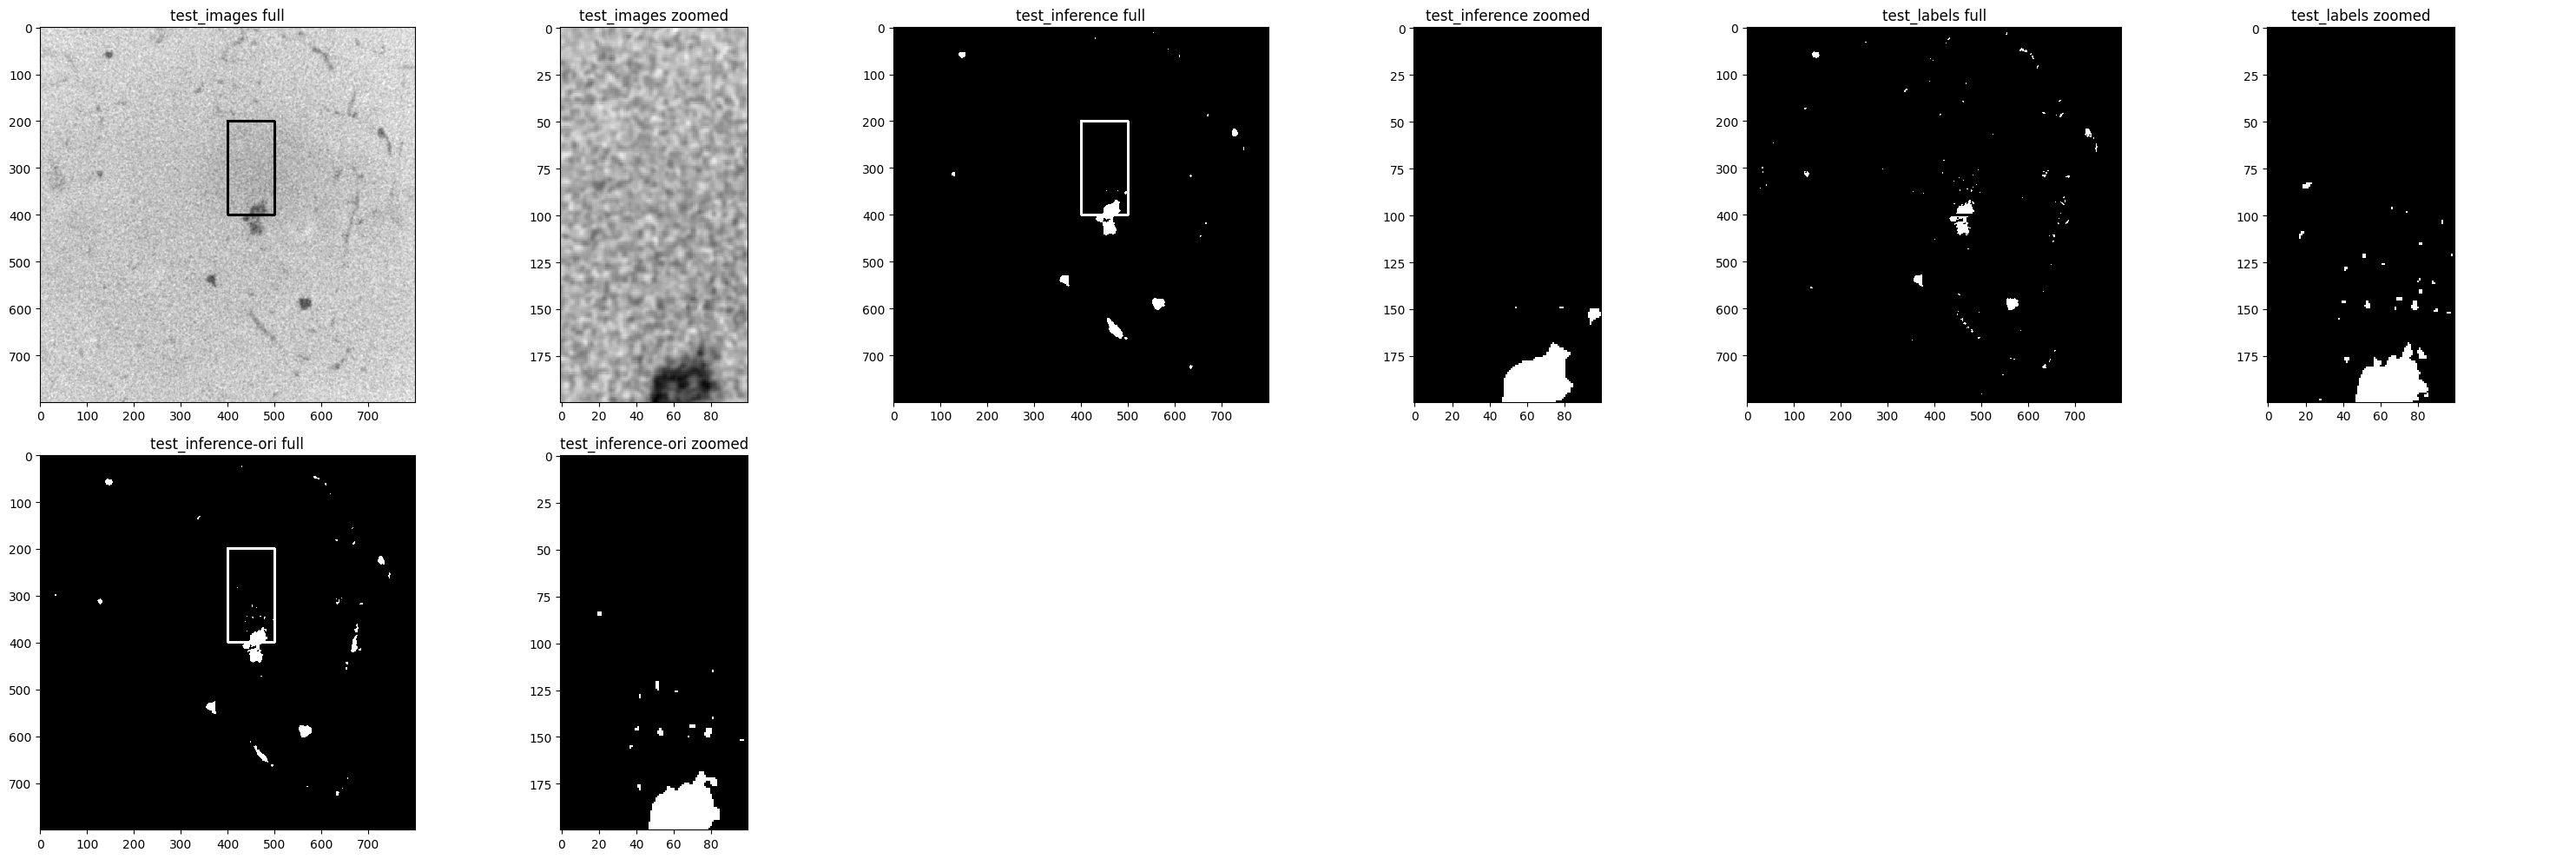

In [20]:
from API_functions.Visual import file_compare as fc
# %matplotlib qt

db = fc.ImageDatabase()
# image_processor.add_result('pre_processed', tpi.user_threshold(image_processor.image, 160))
zoom = fc.ZoomRegion(200, 400, 100, 200)
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_images/', 'test_images')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_labels/', 'test_labels')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference7/', 'test_inference')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference6/', 'test_inference-ori')
image_processor = db.get_image_processor('002_ou_DongYing_13636_roi_selected.png')
image_processor.show_images('test_images', 'test_inference', 'test_labels', "test_inference-ori", zoom_region=zoom)